# Spotify Music: Multi-class Genre Classification

---


## Setup

In [ ]:
# Uncomment to upgrade packages
# !pip install pandas --upgrade --user --quiet
# !pip install numpy --upgrade --user --quiet
# !pip install scipy --upgrade --user --quiet
# !pip install statsmodels --upgrade --user --quiet
# !pip install scikit-learn --upgrade --user --quiet
# !pip install tensorflow --user
%load_ext autoreload

In [ ]:
import numpy as np
import pandas as pd
from pandas.api.types import CategoricalDtype
import random

import matplotlib.pyplot as plt
import seaborn as sns

from time import time
from datetime import timedelta

from sklearn.model_selection import train_test_split, KFold, cross_validate, GridSearchCV, RandomizedSearchCV, cross_val_predict
from sklearn.preprocessing import MinMaxScaler, LabelEncoder
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis, QuadraticDiscriminantAnalysis
from sklearn.neighbors import KNeighborsClassifier
from sklearn.naive_bayes import BernoulliNB, GaussianNB, CategoricalNB
from sklearn.linear_model import LogisticRegressionCV, LogisticRegression
from sklearn.svm import SVC
from sklearn.decomposition import PCA
from sklearn.tree import DecisionTreeClassifier, export_graphviz
from sklearn.ensemble import RandomForestClassifier, VotingClassifier, GradientBoostingClassifier, StackingClassifier, ExtraTreesClassifier, BaggingClassifier
from sklearn.metrics import confusion_matrix, classification_report, accuracy_score, precision_score, recall_score, f1_score, make_scorer
from sklearn.neural_network import MLPClassifier

from imblearn.under_sampling import RandomUnderSampler
from imblearn.over_sampling import SMOTE
from imblearn.combine import SMOTEENN

from collections import Counter

from xgboost import XGBClassifier

from IPython.core.interactiveshell import InteractiveShell

pd.set_option('display.precision', 3)
InteractiveShell.ast_node_interactivity = "all"

In [ ]:
import warnings
warnings.filterwarnings('ignore')

seed = 123
np.random.seed(seed) # for reproducibility

## Exploratory Data Analysis

In [ ]:
# Load Dataset
data = pd.read_csv("genres_v2.csv")

Looking at the data types of the target variables, we have some continuous floating point values, some integers, which may be treated categorical and some objects. The last three columns contain missing values, however, we do not have to worry about them, as we discard them later.

In [ ]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 42305 entries, 0 to 42304
Data columns (total 22 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   danceability      42305 non-null  float64
 1   energy            42305 non-null  float64
 2   key               42305 non-null  int64  
 3   loudness          42305 non-null  float64
 4   mode              42305 non-null  int64  
 5   speechiness       42305 non-null  float64
 6   acousticness      42305 non-null  float64
 7   instrumentalness  42305 non-null  float64
 8   liveness          42305 non-null  float64
 9   valence           42305 non-null  float64
 10  tempo             42305 non-null  float64
 11  type              42305 non-null  object 
 12  id                42305 non-null  object 
 13  uri               42305 non-null  object 
 14  track_href        42305 non-null  object 
 15  analysis_url      42305 non-null  object 
 16  duration_ms       42305 non-null  int64 

Looking at the specific values, we can discard some of the object target variables, as these represent id's, links or song names, which are irrelevant for the classification problem.

In [ ]:
data.head()

,danceability,energy,key,loudness,mode,speechiness,acousticness,instrumentalness,liveness,valence,...,id,uri,track_href,analysis_url,duration_ms,time_signature,genre,song_name,Unnamed: 0,title
0,0.831,0.814,2,-7.364,1,0.420,0.060,1.340e-02,0.056,0.389,...,2Vc6NJ9PW9gD9q343XFRKx,spotify:track:2Vc6NJ9PW9gD9q343XFRKx,https://api.spotify.com/v1/tracks/2Vc6NJ9PW9gD...,https://api.spotify.com/v1/audio-analysis/2Vc6...,124539,4,Dark Trap,Mercury: Retrograde,NaN,NaN
1,0.719,0.493,8,-7.230,1,0.079,0.401,0.000e+00,0.118,0.124,...,7pgJBLVz5VmnL7uGHmRj6p,spotify:track:7pgJBLVz5VmnL7uGHmRj6p,https://api.spotify.com/v1/tracks/7pgJBLVz5Vmn...,https://api.spotify.com/v1/audio-analysis/7pgJ...,224427,4,Dark Trap,Pathology,NaN,NaN
2,0.850,0.893,5,-4.783,1,0.062,0.014,4.140e-06,0.372,0.039,...,0vSWgAlfpye0WCGeNmuNhy,spotify:track:0vSWgAlfpye0WCGeNmuNhy,https://api.spotify.com/v1/tracks/0vSWgAlfpye0...,https://api.spotify.com/v1/audio-analysis/0vSW...,98821,4,Dark Trap,Symbiote,NaN,NaN
3,0.476,0.781,0,-4.710,1,0.103,0.024,0.000e+00,0.114,0.175,...,0VSXnJqQkwuH2ei1nOQ1nu,spotify:track:0VSXnJqQkwuH2ei1nOQ1nu,https://api.spotify.com/v1/tracks/0VSXnJqQkwuH...,https://api.spotify.com/v1/audio-analysis/0VSX...,123661,3,Dark Trap,ProductOfDrugs (Prod. The Virus and Antidote),NaN,NaN
4,0.798,0.624,2,-7.668,1,0.293,0.217,0.000e+00,0.166,0.591,...,4jCeguq9rMTlbMmPHuO7S3,spotify:track:4jCeguq9rMTlbMmPHuO7S3,https://api.spotify.com/v1/tracks/4jCeguq9rMTl...,https://api.spotify.com/v1/audio-analysis/4jCe...,123298,4,Dark Trap,Venom,NaN,NaN


In [ ]:
data.describe()

,danceability,energy,key,loudness,mode,speechiness,acousticness,instrumentalness,liveness,valence,tempo,duration_ms,time_signature,Unnamed: 0
count,42305.000,4.230e+04,42305.000,42305.000,42305.000,42305.000,4.230e+04,42305.000,42305.000,42305.000,42305.000,42305.000,42305.000,20780.000
mean,0.639,7.625e-01,5.370,-6.465,0.549,0.137,9.616e-02,0.283,0.214,0.357,147.474,250865.847,3.973,10483.971
std,0.157,1.838e-01,3.666,2.941,0.498,0.126,1.708e-01,0.371,0.176,0.233,23.845,102957.714,0.268,6052.360
min,0.065,2.430e-04,0.000,-33.357,0.000,0.023,1.070e-06,0.000,0.011,0.019,57.967,25600.000,1.000,0.000
25%,0.524,6.320e-01,1.000,-8.161,0.000,0.049,1.730e-03,0.000,0.100,0.161,129.931,179840.000,4.000,5255.750
50%,0.646,8.030e-01,6.000,-6.234,1.000,0.075,1.640e-02,0.006,0.135,0.322,144.973,224760.000,4.000,10479.500
75%,0.766,9.230e-01,9.000,-4.513,1.000,0.193,1.070e-01,0.722,0.294,0.522,161.464,301133.000,4.000,15709.250
max,0.988,1.000e+00,11.000,3.148,1.000,0.946,9.880e-01,0.989,0.988,0.988,220.290,913052.000,5.000,20999.000


In [ ]:
# Drop columns
drop_cols = ['type', 'id', 'uri', 'track_href', 'analysis_url', 'song_name', 'Unnamed: 0', 'title']
data = data.drop(columns=drop_cols)

We now have 14 columns left, without missing values. We encode these columns in numerical, categorical and the target value.

In [ ]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 42305 entries, 0 to 42304
Data columns (total 14 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   danceability      42305 non-null  float64
 1   energy            42305 non-null  float64
 2   key               42305 non-null  int64  
 3   loudness          42305 non-null  float64
 4   mode              42305 non-null  int64  
 5   speechiness       42305 non-null  float64
 6   acousticness      42305 non-null  float64
 7   instrumentalness  42305 non-null  float64
 8   liveness          42305 non-null  float64
 9   valence           42305 non-null  float64
 10  tempo             42305 non-null  float64
 11  duration_ms       42305 non-null  int64  
 12  time_signature    42305 non-null  int64  
 13  genre             42305 non-null  object 
dtypes: float64(9), int64(4), object(1)
memory usage: 4.5+ MB


In [ ]:
data.describe()

,danceability,energy,key,loudness,mode,speechiness,acousticness,instrumentalness,liveness,valence,tempo,duration_ms,time_signature
count,42305.000,4.230e+04,42305.000,42305.000,42305.000,42305.000,4.230e+04,42305.000,42305.000,42305.000,42305.000,42305.000,42305.000
mean,0.639,7.625e-01,5.370,-6.465,0.549,0.137,9.616e-02,0.283,0.214,0.357,147.474,250865.847,3.973
std,0.157,1.838e-01,3.666,2.941,0.498,0.126,1.708e-01,0.371,0.176,0.233,23.845,102957.714,0.268
min,0.065,2.430e-04,0.000,-33.357,0.000,0.023,1.070e-06,0.000,0.011,0.019,57.967,25600.000,1.000
25%,0.524,6.320e-01,1.000,-8.161,0.000,0.049,1.730e-03,0.000,0.100,0.161,129.931,179840.000,4.000
50%,0.646,8.030e-01,6.000,-6.234,1.000,0.075,1.640e-02,0.006,0.135,0.322,144.973,224760.000,4.000
75%,0.766,9.230e-01,9.000,-4.513,1.000,0.193,1.070e-01,0.722,0.294,0.522,161.464,301133.000,4.000
max,0.988,1.000e+00,11.000,3.148,1.000,0.946,9.880e-01,0.989,0.988,0.988,220.290,913052.000,5.000


In [ ]:
# Tag column type
numerical_cols = ['danceability', 'energy', 'loudness', 'speechiness', 'acousticness', 'instrumentalness', 'liveness', 'valence', 'tempo', 'duration_ms']
categorical_cols = ['key', 'mode', 'time_signature']
target = 'genre'

Looking at the distribution of the target variable (genre), we see that some values occur more often than others. Expecially, the genre 'pop' is underrepresented. We could try oversampling this genre later to increase the performance of some learning methods.

In [ ]:
data['genre'].value_counts()

genre
Underground Rap    5875
Dark Trap          4578
Hiphop             3028
trance             2999
trap               2987
techhouse          2975
dnb                2966
psytrance          2961
techno             2956
hardstyle          2936
RnB                2099
Trap Metal         1956
Rap                1848
Emo                1680
Pop                 461
Name: count, dtype: int64

<Axes: ylabel='genre'>

Text(0.5, 1.0, 'Distribution of Target Values')

Text(0.5, 0, 'Count')

Text(0, 0.5, 'Genre')

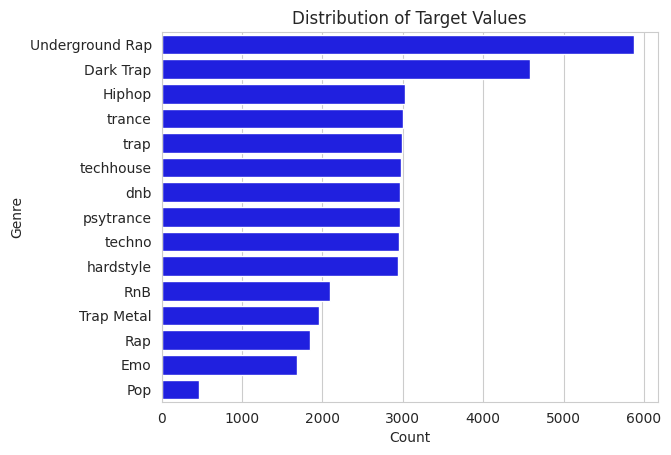

In [ ]:
sns.set_style("whitegrid")
genre_counts = data['genre'].value_counts()
sns.barplot(x=genre_counts.values, y=genre_counts.index, color="blue")
plt.title('Distribution of Target Values')
plt.xlabel('Count')
plt.ylabel('Genre')
plt.show()

Looking at the distribution of the categorical columns, we see that some values are imbalanced or overrepresentated. For example the time_signature is dominated by the category 4, the key is dominated by the category 1.

<Figure size 1500x1500 with 0 Axes>

<Axes: >

<Axes: xlabel='key', ylabel='Count'>

Text(0.5, 1.0, 'key')

<Axes: >

<Axes: xlabel='mode', ylabel='Count'>

Text(0.5, 1.0, 'mode')

<Axes: >

<Axes: xlabel='time_signature', ylabel='Count'>

Text(0.5, 1.0, 'time_signature')

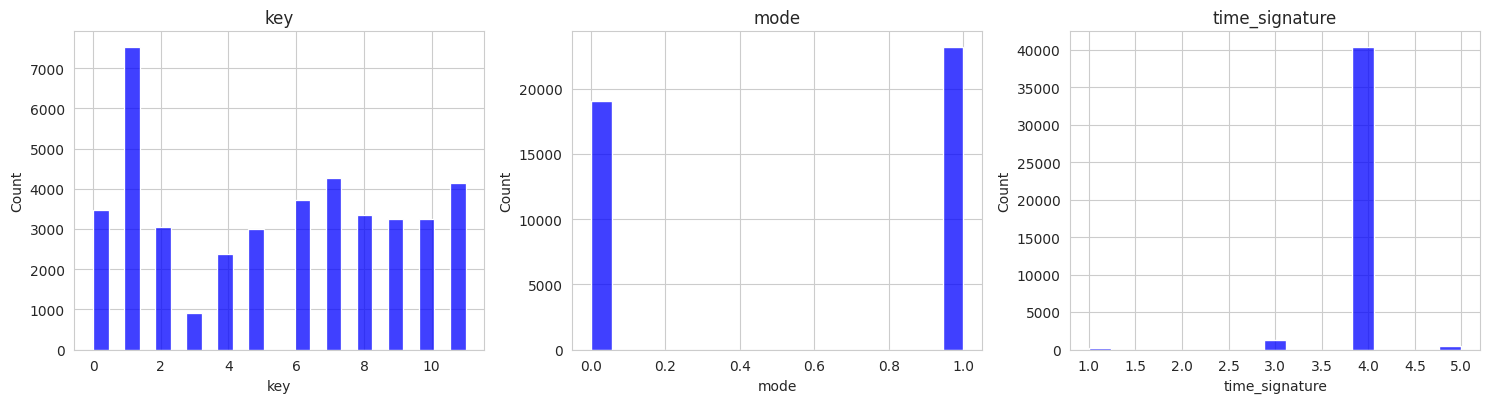

In [ ]:
# Plot distribution of categorical columns
features_to_plot = categorical_cols
plt.figure(figsize=(15, 15))

for i, feature in enumerate(features_to_plot, 1):
    plt.subplot(4, 3, i)
    sns.histplot(data[feature], color="blue")
    plt.title(feature)

plt.tight_layout()
plt.show()

Looking at the distribution of the numerical columns, we see that most of the distributions are not gaussian. Most of the columns already have a reasonable scale, however, we are going to apply min-max scaling later, to make sure that all variables have similar scaling, hence our models will perform better.

<Figure size 1500x1500 with 0 Axes>

<Axes: >

<Axes: xlabel='danceability', ylabel='Count'>

Text(0.5, 1.0, 'danceability')

<Axes: >

<Axes: xlabel='energy', ylabel='Count'>

Text(0.5, 1.0, 'energy')

<Axes: >

<Axes: xlabel='loudness', ylabel='Count'>

Text(0.5, 1.0, 'loudness')

<Axes: >

<Axes: xlabel='speechiness', ylabel='Count'>

Text(0.5, 1.0, 'speechiness')

<Axes: >

<Axes: xlabel='acousticness', ylabel='Count'>

Text(0.5, 1.0, 'acousticness')

<Axes: >

<Axes: xlabel='instrumentalness', ylabel='Count'>

Text(0.5, 1.0, 'instrumentalness')

<Axes: >

<Axes: xlabel='liveness', ylabel='Count'>

Text(0.5, 1.0, 'liveness')

<Axes: >

<Axes: xlabel='valence', ylabel='Count'>

Text(0.5, 1.0, 'valence')

<Axes: >

<Axes: xlabel='tempo', ylabel='Count'>

Text(0.5, 1.0, 'tempo')

<Axes: >

<Axes: xlabel='duration_ms', ylabel='Count'>

Text(0.5, 1.0, 'duration_ms')

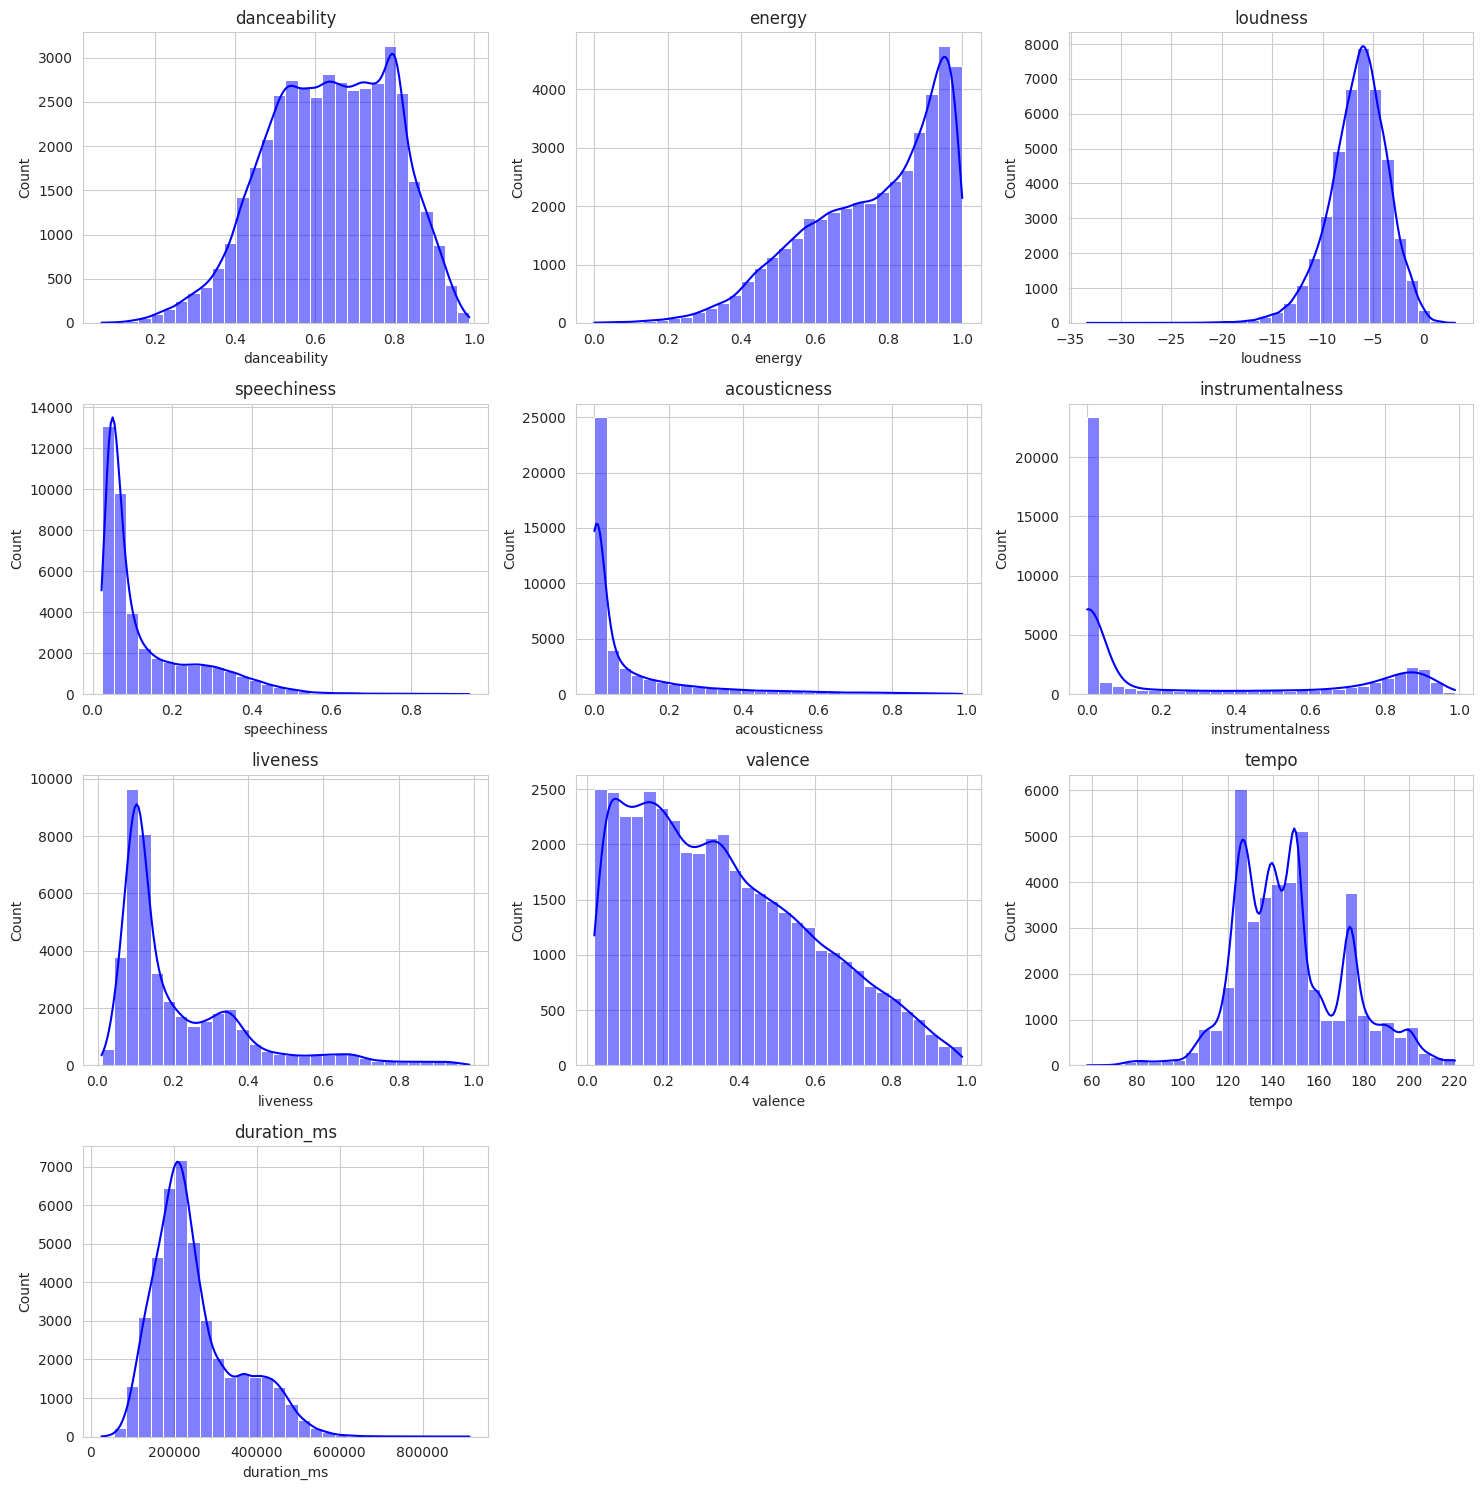

In [ ]:
# Plot distribution of numerical columns
features_to_plot = numerical_cols
plt.figure(figsize=(15, 15))

for i, feature in enumerate(features_to_plot, 1):
    plt.subplot(4, 3, i)
    sns.histplot(data[feature], bins=30, kde=True, color="blue")
    plt.title(feature)

plt.tight_layout()
plt.show()

The correlation matrix shows that some variables are somewhat related to each other. Later mybe we can use this information to exclude a few features, if they are highly correlated. For example energy-loudness, energy- accousticness, duration_ms-instrumentalness. However, we esteem that this is not enough to delete one of them.

<Figure size 1000x800 with 0 Axes>

<Axes: >

Text(0.5, 1.0, 'Correlation Matrix of Features')

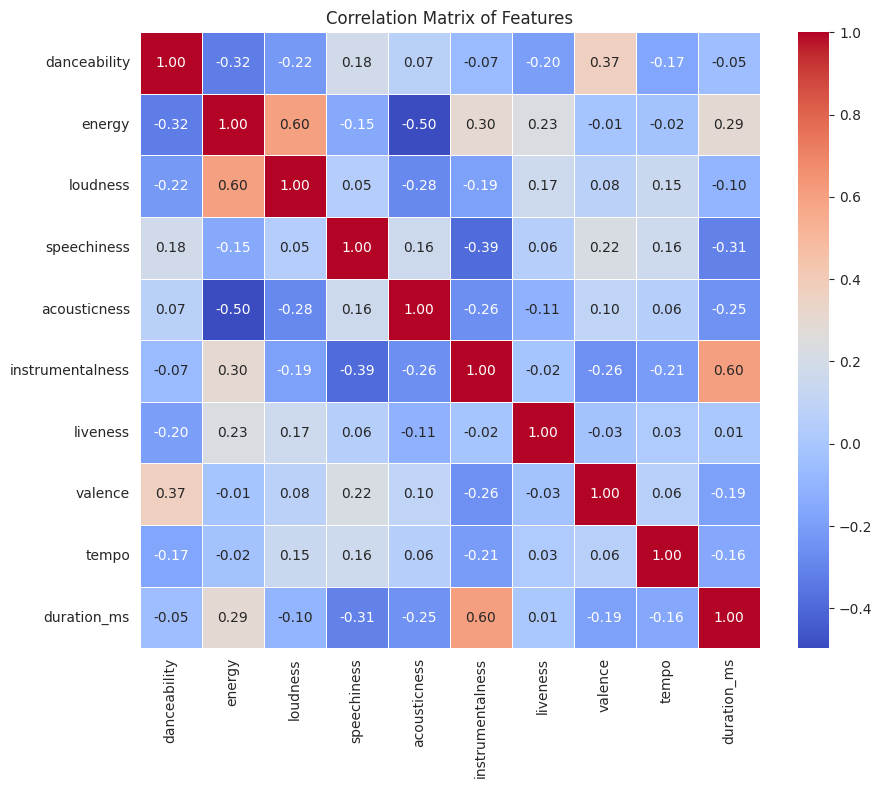

In [ ]:
# Correlation Analysis
plt.figure(figsize=(10, 8))
correlation_matrix = data[features_to_plot].corr()
sns.heatmap(correlation_matrix, annot=True, cmap="coolwarm", fmt=".2f", linewidths=.5)
plt.title('Correlation Matrix of Features')
plt.show()

### Average values for numerical features


<Figure size 1500x1000 with 0 Axes>

<Axes: >

<Axes: xlabel='genre'>

Text(0, 0.5, 'average energy')

Text(0.5, 1.0, 'Average energy by genre')

<Axes: >

<Axes: xlabel='genre'>

Text(0, 0.5, 'average loudness')

Text(0.5, 1.0, 'Average loudness by genre')

<Axes: >

<Axes: xlabel='genre'>

Text(0, 0.5, 'average speechiness')

Text(0.5, 1.0, 'Average speechiness by genre')

<Axes: >

<Axes: xlabel='genre'>

Text(0, 0.5, 'average acousticness')

Text(0.5, 1.0, 'Average acousticness by genre')

<Axes: >

<Axes: xlabel='genre'>

Text(0, 0.5, 'average instrumentalness')

Text(0.5, 1.0, 'Average instrumentalness by genre')

<Axes: >

<Axes: xlabel='genre'>

Text(0, 0.5, 'average liveness')

Text(0.5, 1.0, 'Average liveness by genre')

<Axes: >

<Axes: xlabel='genre'>

Text(0, 0.5, 'average valence')

Text(0.5, 1.0, 'Average valence by genre')

<Axes: >

<Axes: xlabel='genre'>

Text(0, 0.5, 'average tempo')

Text(0.5, 1.0, 'Average tempo by genre')

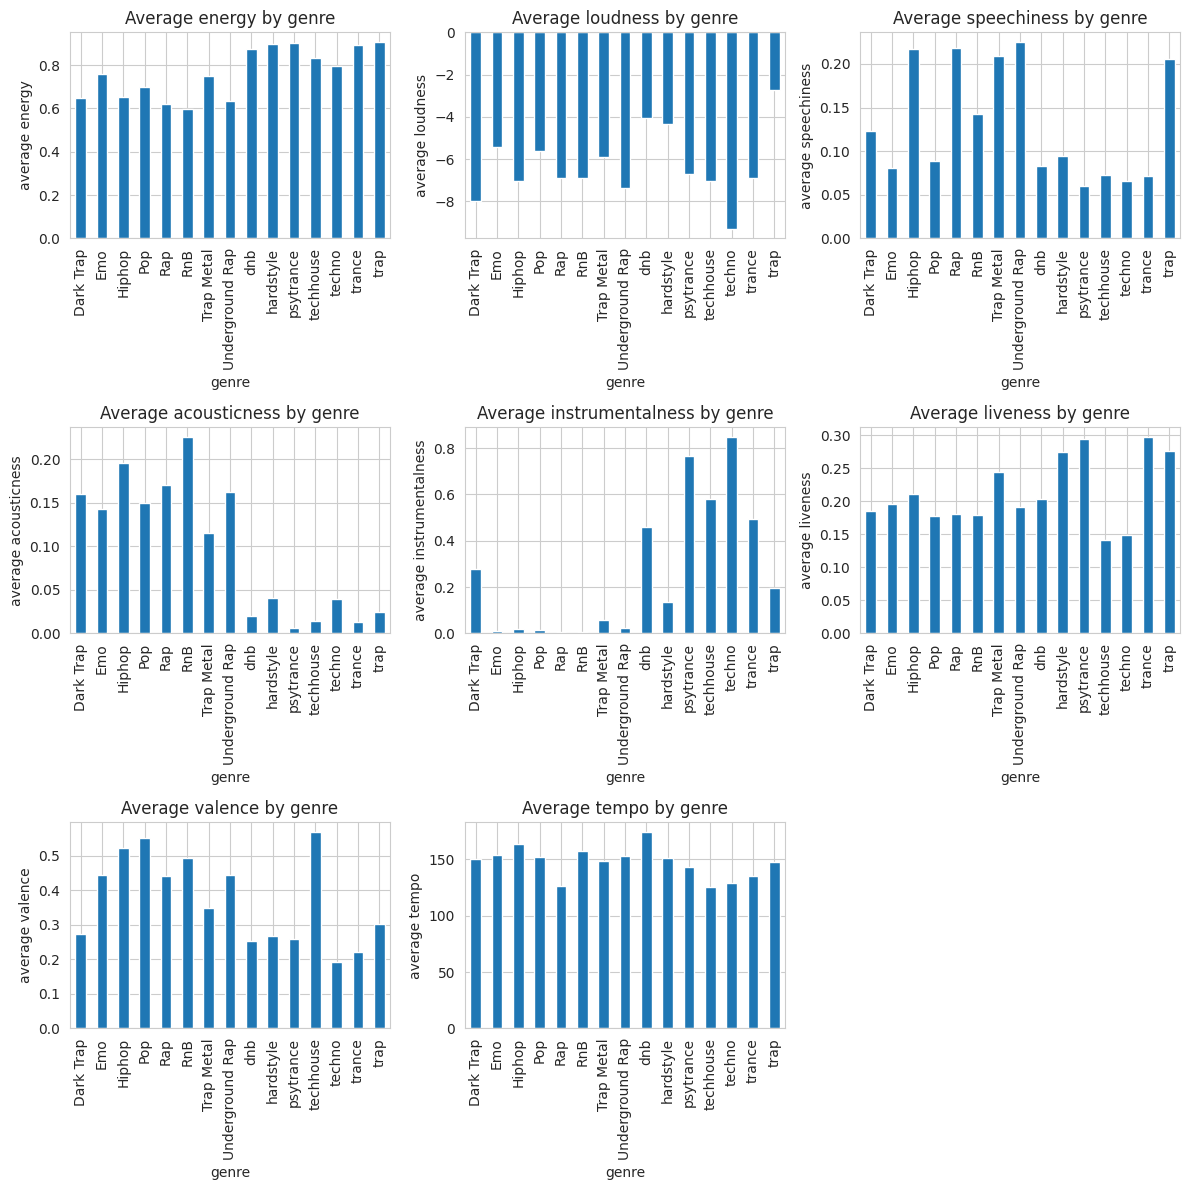

In [ ]:
features_to_plot = [ 'energy', 'loudness', 'speechiness', 'acousticness', 'instrumentalness', 'liveness', 'valence', 'tempo']
plt.figure(figsize=(15, 10))

for i, feature in enumerate(features_to_plot, 1):
    plt.subplot(3, 3, i)
    # Grouping by genre and calculating the mean of the feature for each genre
    avg_values_by_genre = data.groupby('genre')[feature].mean()
    avg_values_by_genre.plot(kind='bar', figsize=(12, 12))
    plt.ylabel(f'average {feature}')
    # Customizi the title
    plt.title(f'Average {feature} by genre')

plt.tight_layout()
plt.show()

### Exploring the song durations for the genres

In [ ]:
data_explore = data.copy()

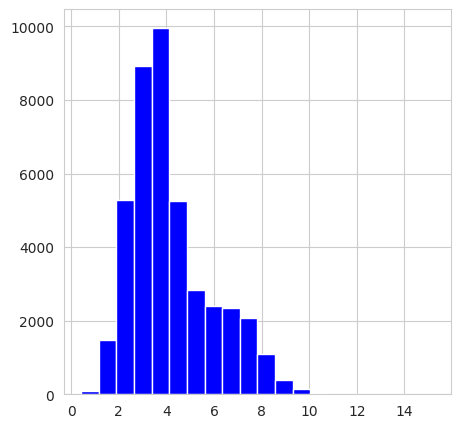

In [ ]:
data_explore['duration_mins'] = data_explore['duration_ms']/60000
data_explore.duration_mins.hist(bins=20,figsize=(5,5), color='blue');

<Axes: xlabel='duration_category'>

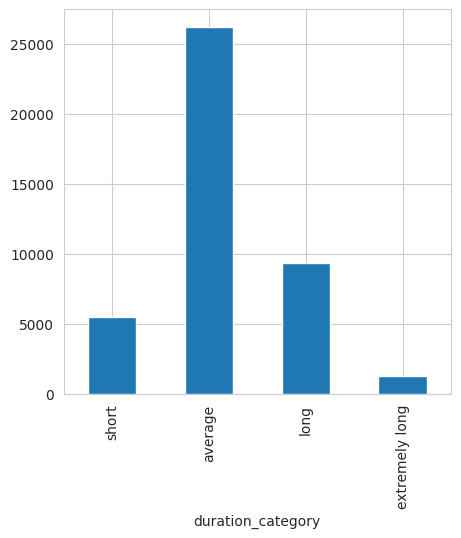

In [ ]:
bins = [0, 2.5, 5, 8, 16]
data_explore['duration_category'] = pd.cut(data_explore['duration_mins'], bins=bins, labels=['short', 'average','long','extremely long'])
data_explore['duration_category'].value_counts().sort_index().plot.bar(figsize=(5,5))

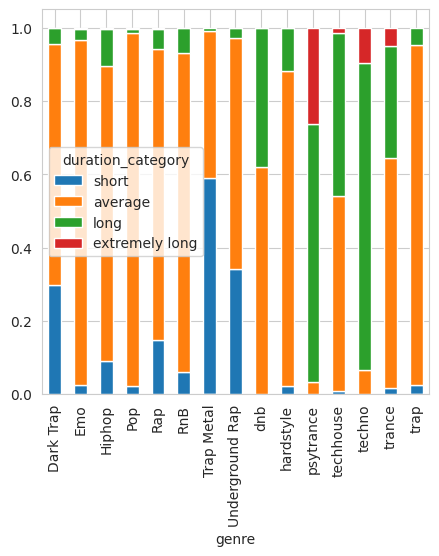

In [ ]:
pd.crosstab(data_explore['duration_category'],
            data_explore.genre,
            normalize="columns").T.plot.bar(stacked=True,
                                            figsize=(5,5));

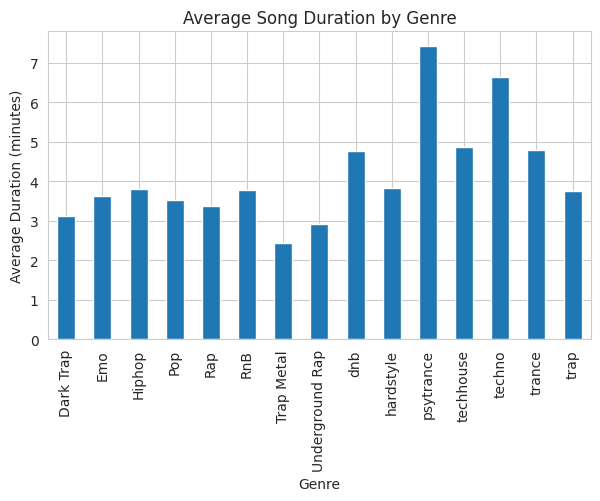

In [ ]:
mean_duration_by_genre = data_explore.groupby('genre')['duration_mins'].mean()

# Plot the mean duration for each genre
mean_duration_by_genre.plot(kind='bar', figsize=(7, 4));

# Customizing the plot
plt.title('Average Song Duration by Genre');
plt.xlabel('Genre');
plt.ylabel('Average Duration (minutes)');
plt.xticks(rotation=90);  # Rotate x-axis labels for better readability

# Display the plot
plt.show();

### Exploring a few categorical variables

In [ ]:
data_explore['mode']=data_explore['mode'].astype('object')
data_explore.key=data_explore.key.astype('object')
data_explore.time_signature = data_explore.time_signature.astype('object')

In [ ]:
data_explore['mode'].replace([0,1], ['minor', 'major'], inplace = True)
data_explore.time_signature.replace([1, 3, 4, 5], ['1/4','3/4','4/4','5/4'], inplace=True)
data_explore.key.replace([0,1,2,3,4,5,6,7,8,9,10,11],['C', 'C#', 'D', 'D#', 'E', 'F', 'F#', 'G', 'G#','A','A#','B'], inplace=True)

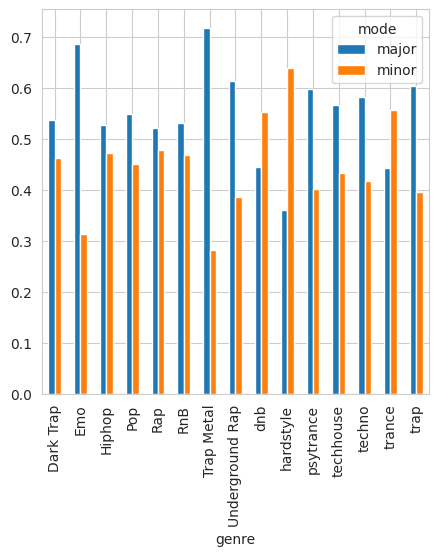

In [ ]:
pd.crosstab(data_explore['mode'],
            data_explore.genre,
            normalize="columns").T.plot.bar(figsize=(5,5));

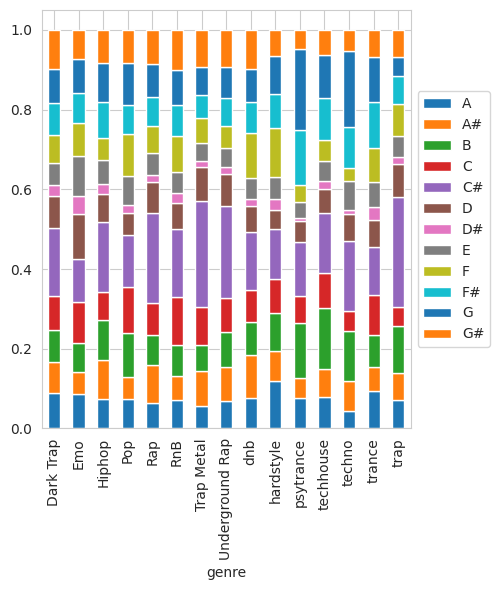

In [ ]:
ax = pd.crosstab(data_explore['key'],
                 data_explore.genre,
                 normalize="columns").T.plot.bar(stacked=True,
                                                 figsize=(6,6))

ax.legend(loc='center left', bbox_to_anchor=(1.0, 0.5))

plt.tight_layout(rect=[0, 0, 0.85, 1])

plt.show()

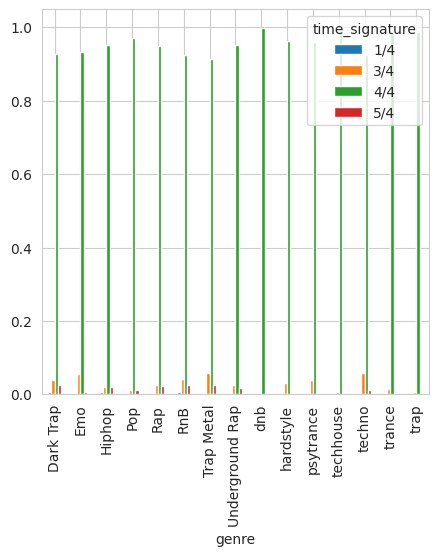

In [ ]:
pd.crosstab(data_explore['time_signature'],
            data_explore.genre,
            normalize="columns").T.plot.bar(figsize=(5,5));

## Preprocessing


Genre Selection

In [ ]:
data.drop(data.loc[data['genre']=="Pop"].index, inplace=True)
data = data.reset_index(drop = True)

data = data.replace("Underground Rap", "Rap")
data = data.replace("Hiphop", "Rap")
data = data.replace("Trap Metal", "Rap")
data = data.replace("Dark Trap", "Rap")

rows_drop = []
for i in range(len(data)):
  if data.iloc[i]['genre'] == 'Rap':
    if random.random()<0.85:
      rows_drop.append(i)
data.drop(index = rows_drop, inplace=True)

Feature Selection

In [ ]:
drop_cols = ['key', 'mode', 'time_signature']
data = data.drop(columns=drop_cols)

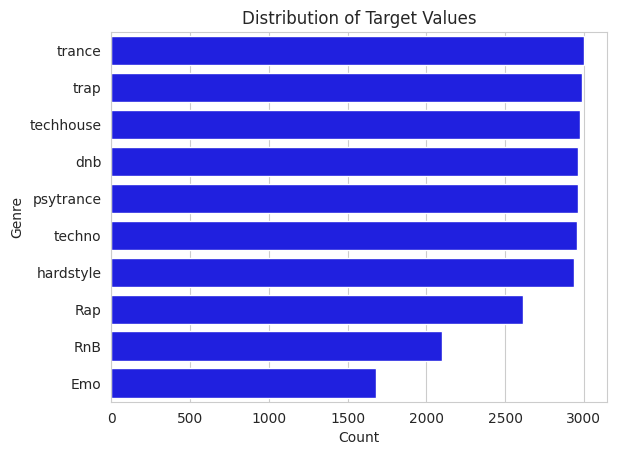

In [ ]:
sns.set_style("whitegrid")
genre_counts = data['genre'].value_counts()
sns.barplot(x=genre_counts.values, y=genre_counts.index, color="blue")
plt.title('Distribution of Target Values')
plt.xlabel('Count')
plt.ylabel('Genre')
plt.show();

Validation Protocol

In [ ]:
X = data.loc[:,data.columns != target]
y = data[target]

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=123)

X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.25, random_state=321)

Oversampling Classes

In [ ]:
smote = SMOTE(sampling_strategy='not majority', random_state=123)
X_train, y_train = smote.fit_resample(X_train, y_train)

Data Transformation

In [ ]:
def preprocessing(X, y, scaler=None):

    # Scale the numerical columns
    if scaler is None:
        # Only fit the train data
        scaler = MinMaxScaler()
        X.loc[:,numerical_cols] = scaler.fit_transform(X[numerical_cols])
    else:
        X.loc[:,numerical_cols] = scaler.transform(X[numerical_cols])

    # Apply one-hot-encoding to the categorical columns
    #X = pd.get_dummies(X,drop_first=True)
    return X, y, scaler

X_train, y_train, scaler = preprocessing(X_train,y_train)
X_val, y_val, _ = preprocessing(X_val,y_val,scaler)
X_test, y_test, _ = preprocessing(X_test,y_test,scaler)

## Train Models


In [ ]:
def cv_predict(model, X_train, y_train, X_val=X_val, y_val=y_val):
    # Perform cross-validation
    y_pred = cross_val_predict(model, X_train, y_train, cv=5)

    # Initialize a DataFrame to store the results
    r = pd.DataFrame(index=[], columns=['Fold', 'Accuracy', 'Precision', 'Recall', 'F1-Score'])

    # Calculate classification report for each fold
    for fold in range(5):
        start_index = fold * len(y_train) // 5
        end_index = (fold + 1) * len(y_train) // 5

        fold_report = classification_report(y_train[start_index:end_index],
                                            y_pred[start_index:end_index],
                                            output_dict=True)

        accuracy = fold_report['accuracy']
        precision = fold_report['macro avg']['precision']
        recall = fold_report['macro avg']['recall']
        f1_score = fold_report['macro avg']['f1-score']

        # Add fold results to DataFrame
        fold_results = pd.DataFrame({'Fold': [fold + 1],
                                    'Accuracy': [accuracy],
                                    'Precision': [precision],
                                    'Recall': [recall],
                                    'F1-Score': [f1_score]})
        r = pd.concat([r, fold_results], ignore_index=True)

    # Calculate average values across folds
    avg_results = r.mean()

    # Add results to list
    results.loc[model.__class__.__name__, :] = [avg_results[1], avg_results[2], avg_results[3], avg_results[4]]
    return results.sort_values(by='F1-Score', ascending=False)

In [ ]:
def confusion(true, pred, xgb=False):
    if xgb:
      true = pd.Series(true, name='target')
    pred = pd.Series(pred)
    true.name = 'target'
    pred.name = 'predicted'
    cm = pd.crosstab(true.reset_index(drop=True), pred.reset_index(drop=True))
    cm = cm[cm.index]
    return cm

In [ ]:
# Create empty datafram for results
results = pd.DataFrame(index=[], columns= ['Accuracy', 'Precision', 'Recall', 'F1-Score'])

# Define scoring dict for GridSearchCV
scoring_dict = {
    'f1_mac': 'f1_macro',
    'acc': 'accuracy'
}

### LDA Model

In [ ]:
lda_model = LinearDiscriminantAnalysis()

cv_predict(lda_model, X_train, y_train)

,Accuracy,Precision,Recall,F1-Score
LinearDiscriminantAnalysis,0.659,0.655,0.655,0.651


In [ ]:
lda_model.fit(X_train, y_train)
print(classification_report(y_val, lda_model.predict(X_val)))
confusion(y_val, lda_model.predict(X_val))

LinearDiscriminantAnalysis()

              precision    recall  f1-score   support

         Emo       0.39      0.50      0.44       316
         Rap       0.65      0.50      0.57       532
         RnB       0.55      0.54      0.55       406
         dnb       0.83      0.74      0.78       584
   hardstyle       0.50      0.60      0.55       596
   psytrance       0.69      0.81      0.74       603
   techhouse       0.78      0.75      0.76       601
      techno       0.71      0.81      0.75       578
      trance       0.64      0.50      0.56       603
        trap       0.71      0.65      0.68       616

    accuracy                           0.65      5435
   macro avg       0.65      0.64      0.64      5435
weighted avg       0.66      0.65      0.65      5435



predicted,Emo,Rap,RnB,dnb,hardstyle,psytrance,techhouse,techno,trance,trap
target,,,,,,,,,,
Emo,157,6,54,18,61,1,9,0,6,4
Rap,26,268,99,14,24,0,25,4,26,46
RnB,51,94,221,12,3,0,23,0,0,2
dnb,36,5,9,434,60,8,0,1,1,30
hardstyle,90,1,1,21,360,8,3,1,48,63
psytrance,0,0,1,1,6,488,11,71,21,4
techhouse,3,14,3,0,4,11,449,89,22,6
techno,0,1,0,0,0,56,35,466,20,0
trance,12,4,3,0,100,132,17,25,303,7


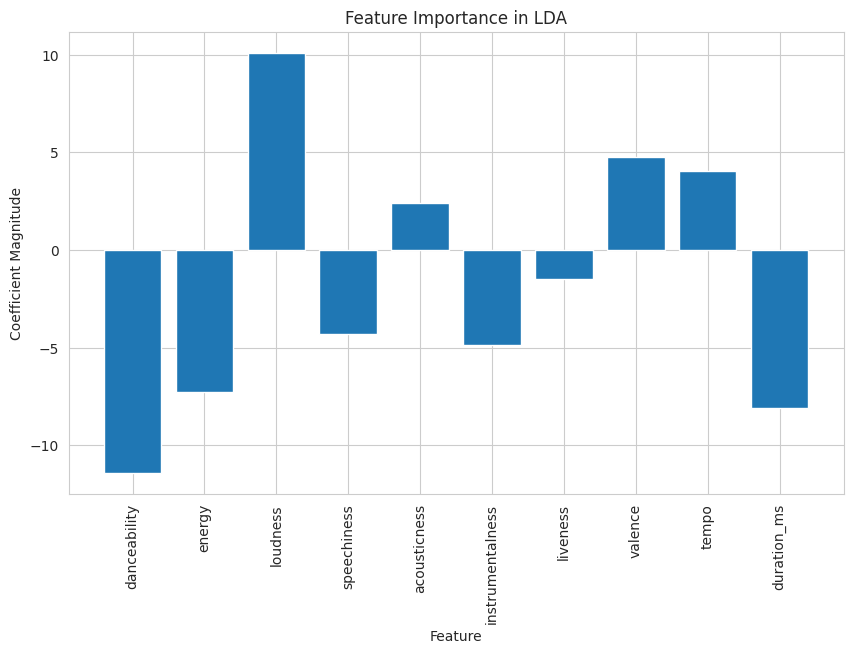

In [ ]:
# Retrieve coefficients
lda_model.fit(X_train, y_train)
coefficients = lda_model.coef_

# Plot feature importance
plt.figure(figsize=(10, 6))
plt.bar(range(len(coefficients[0])), coefficients[0])
plt.xlabel('Feature')
plt.ylabel('Coefficient Magnitude')
plt.title('Feature Importance in LDA')
plt.xticks(range(len(data.columns)-1), data.columns[:-1].tolist(), rotation=90)
plt.show();

### QDA Model


First, we try to find the best value for the regularization parameter.

In [ ]:
qda_model = QuadraticDiscriminantAnalysis()

# Define parameter grid for GridSearchCV
regularization_parameters = [0, 0.0001, 0.001, 0.01, 0.1, 0.5, 1]
param_grid = {'reg_param': regularization_parameters}

# Perform grid search with cross-validation
qda_cv = GridSearchCV(qda_model, param_grid, cv=5, scoring='f1_macro')
qda_cv.fit(X_train, y_train)

# Get best parameters
best_params = qda_cv.best_params_
print("Best parameters:", best_params)

GridSearchCV(cv=5, estimator=QuadraticDiscriminantAnalysis(),
             param_grid={'reg_param': [0, 0.0001, 0.001, 0.01, 0.1, 0.5, 1]},
             scoring='f1_macro')

Best parameters: {'reg_param': 0}


In [ ]:
# Create model with best parameters
qda_best = QuadraticDiscriminantAnalysis(**best_params)
cv_predict(qda_best, X_train, y_train)

,Accuracy,Precision,Recall,F1-Score
QuadraticDiscriminantAnalysis,0.769,0.77,0.768,0.759
LinearDiscriminantAnalysis,0.659,0.655,0.655,0.651


In [ ]:
qda_best.fit(X_train, y_train)
print(classification_report(y_val, qda_best.predict(X_val)))
confusion(y_val, qda_best.predict(X_val))

QuadraticDiscriminantAnalysis(reg_param=0)

              precision    recall  f1-score   support

         Emo       0.57      0.70      0.63       316
         Rap       0.67      0.34      0.45       532
         RnB       0.48      0.83      0.61       406
         dnb       0.99      0.95      0.97       584
   hardstyle       0.81      0.79      0.80       596
   psytrance       0.80      0.90      0.85       603
   techhouse       0.87      0.86      0.86       601
      techno       0.79      0.81      0.80       578
      trance       0.79      0.73      0.76       603
        trap       0.84      0.70      0.76       616

    accuracy                           0.77      5435
   macro avg       0.76      0.76      0.75      5435
weighted avg       0.78      0.77      0.76      5435



predicted,Emo,Rap,RnB,dnb,hardstyle,psytrance,techhouse,techno,trance,trap
target,,,,,,,,,,
Emo,221,10,64,2,8,0,3,0,8,0
Rap,33,183,256,3,8,2,5,6,19,17
RnB,36,21,338,1,1,0,7,0,1,1
dnb,6,15,8,555,0,0,0,0,0,0
hardstyle,44,7,2,0,469,15,0,0,0,59
psytrance,1,2,1,0,5,540,0,25,25,4
techhouse,6,9,5,0,0,0,514,51,16,0
techno,0,4,0,0,0,28,48,470,28,0
trance,18,4,10,0,0,78,11,42,438,2


### KNN Model


First, we try to find the best value for the number of neighbours.

In [ ]:
knn_model = KNeighborsClassifier()

# Define parameter grid
k_values = list(range(1, 21))
param_grid = {'n_neighbors': k_values}

# Perform grid search with cross-validation
knn_cv = GridSearchCV(knn_model, param_grid, cv=5, scoring='f1_macro')
knn_cv.fit(X_train, y_train)

# Get best parameters
best_params = knn_cv.best_params_
print("Best parameters:", best_params)

GridSearchCV(cv=5, estimator=KNeighborsClassifier(),
             param_grid={'n_neighbors': [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12,
                                         13, 14, 15, 16, 17, 18, 19, 20]},
             scoring='f1_macro')

Best parameters: {'n_neighbors': 1}


In [ ]:
# Create model with best parameters
knn_best = KNeighborsClassifier(**best_params)
cv_predict(knn_best, X_train, y_train)

,Accuracy,Precision,Recall,F1-Score
QuadraticDiscriminantAnalysis,0.769,0.77,0.768,0.759
KNeighborsClassifier,0.752,0.742,0.75,0.744
LinearDiscriminantAnalysis,0.659,0.655,0.655,0.651


In [ ]:
knn_best.fit(X_train, y_train)
print(classification_report(y_val, knn_best.predict(X_val)))
confusion(y_val, knn_best.predict(X_val))

KNeighborsClassifier(n_neighbors=1)

              precision    recall  f1-score   support

         Emo       0.56      0.65      0.60       316
         Rap       0.58      0.47      0.52       532
         RnB       0.50      0.52      0.51       406
         dnb       0.94      0.92      0.93       584
   hardstyle       0.76      0.78      0.77       596
   psytrance       0.82      0.84      0.83       603
   techhouse       0.80      0.80      0.80       601
      techno       0.73      0.79      0.76       578
      trance       0.72      0.71      0.71       603
        trap       0.77      0.76      0.76       616

    accuracy                           0.74      5435
   macro avg       0.72      0.72      0.72      5435
weighted avg       0.74      0.74      0.74      5435



predicted,Emo,Rap,RnB,dnb,hardstyle,psytrance,techhouse,techno,trance,trap
target,,,,,,,,,,
Emo,206,16,35,12,23,1,5,2,9,7
Rap,27,248,143,15,21,4,14,6,20,34
RnB,56,106,210,6,0,1,13,2,6,6
dnb,18,8,7,540,6,1,0,0,0,4
hardstyle,26,7,3,0,464,8,1,2,20,65
psytrance,1,1,0,0,7,505,7,37,41,4
techhouse,3,12,8,0,0,3,480,72,19,4
techno,0,3,0,0,0,32,53,459,29,2
trance,14,11,2,0,20,53,18,44,428,13


### Naive Bayes Model

In [ ]:
gaussian_nb = GaussianNB()

# Define parameter grid
var_smoothing_values = [1e-9, 1e-8, 1e-7, 1e-6, 1e-5,1e-4, 1e-3, 1e-2, 1e-1]
param_grid = {'var_smoothing': var_smoothing_values}

# Perform grid search with cross-validation
gnb_cv = GridSearchCV(gaussian_nb, param_grid, cv=5, scoring='f1_macro')
gnb_cv.fit(X_train, y_train)

# Get best parameters
best_params = gnb_cv.best_params_
print("Best parameters:", best_params)

GridSearchCV(cv=5, estimator=GaussianNB(),
             param_grid={'var_smoothing': [1e-09, 1e-08, 1e-07, 1e-06, 1e-05,
                                           0.0001, 0.001, 0.01, 0.1]},
             scoring='f1_macro')

Best parameters: {'var_smoothing': 1e-09}


In [ ]:
gnb_best = GaussianNB(**best_params)

cv_predict(gnb_best, X_train, y_train)

,Accuracy,Precision,Recall,F1-Score
QuadraticDiscriminantAnalysis,0.769,0.77,0.768,0.759
KNeighborsClassifier,0.752,0.742,0.75,0.744
GaussianNB,0.735,0.737,0.735,0.72
LinearDiscriminantAnalysis,0.659,0.655,0.655,0.651


In [ ]:
gaussian_nb.fit(X_train, y_train)
print(classification_report(y_val, gaussian_nb.predict(X_val)))
confusion(y_val, gaussian_nb.predict(X_val))

GaussianNB()

              precision    recall  f1-score   support

         Emo       0.53      0.61      0.57       316
         Rap       0.62      0.25      0.36       532
         RnB       0.45      0.84      0.59       406
         dnb       0.98      0.95      0.97       584
   hardstyle       0.77      0.76      0.77       596
   psytrance       0.75      0.86      0.80       603
   techhouse       0.87      0.84      0.86       601
      techno       0.74      0.79      0.76       578
      trance       0.74      0.66      0.70       603
        trap       0.81      0.67      0.73       616

    accuracy                           0.73      5435
   macro avg       0.73      0.72      0.71      5435
weighted avg       0.75      0.73      0.72      5435



predicted,Emo,Rap,RnB,dnb,hardstyle,psytrance,techhouse,techno,trance,trap
target,,,,,,,,,,
Emo,193,7,69,5,15,0,4,3,12,8
Rap,28,135,294,5,11,1,3,12,24,19
RnB,35,20,343,1,1,0,5,1,0,0
dnb,7,12,8,557,0,0,0,0,0,0
hardstyle,50,2,2,0,455,21,0,0,1,65
psytrance,0,0,1,0,4,518,1,45,33,1
techhouse,8,7,10,0,0,0,505,61,10,0
techno,0,12,1,0,0,39,46,455,25,0
trance,26,2,15,0,0,104,15,41,396,4


### Logistic Regression Model

First, we try to find the best value for the regularization parameter C.

In [ ]:
logreg_model = LogisticRegression();

# Define parameter grid
lambdas = [0.00001, 0.0001, 0.001, 0.01, 0.1, 1, 10]
Cs = [1/l for l in lambdas]
param_grid = {'C': Cs}

# Perform grid search with cross-validation
logreg_cv = GridSearchCV(logreg_model, param_grid, cv=5, scoring='f1_macro')
logreg_cv.fit(X_train, y_train)

# Get best parameters
best_params = logreg_cv.best_params_
print("Best parameters:", best_params)

GridSearchCV(cv=5, estimator=LogisticRegression(),
             param_grid={'C': [99999.99999999999, 10000.0, 1000.0, 100.0, 10.0,
                               1.0, 0.1]},
             scoring='f1_macro')

Best parameters: {'C': 1000.0}


In [ ]:
# Create model with best parameters
logreg_best = LogisticRegression(**best_params)
cv_predict(logreg_best, X_train, y_train)

,Accuracy,Precision,Recall,F1-Score
QuadraticDiscriminantAnalysis,0.769,0.77,0.768,0.759
KNeighborsClassifier,0.752,0.742,0.75,0.744
GaussianNB,0.735,0.737,0.735,0.72
LogisticRegression,0.722,0.71,0.717,0.711
LinearDiscriminantAnalysis,0.659,0.655,0.655,0.651


In [ ]:
logreg_best.fit(X_train, y_train)
print(classification_report(y_val, logreg_best.predict(X_val)))
confusion(y_val, logreg_best.predict(X_val))

LogisticRegression(C=1000.0)

              precision    recall  f1-score   support

         Emo       0.37      0.51      0.43       316
         Rap       0.64      0.54      0.59       532
         RnB       0.55      0.56      0.56       406
         dnb       0.87      0.88      0.87       584
   hardstyle       0.73      0.62      0.67       596
   psytrance       0.83      0.85      0.84       603
   techhouse       0.78      0.81      0.79       601
      techno       0.78      0.83      0.80       578
      trance       0.70      0.70      0.70       603
        trap       0.77      0.73      0.75       616

    accuracy                           0.72      5435
   macro avg       0.70      0.70      0.70      5435
weighted avg       0.72      0.72      0.72      5435



predicted,Emo,Rap,RnB,dnb,hardstyle,psytrance,techhouse,techno,trance,trap
target,,,,,,,,,,
Emo,160,11,44,28,19,0,7,0,42,5
Rap,26,289,106,16,14,0,27,6,24,24
RnB,57,78,228,16,1,0,25,0,0,1
dnb,31,12,6,512,11,2,0,0,0,10
hardstyle,110,7,2,12,369,17,0,0,13,66
psytrance,0,3,1,1,1,510,8,36,33,10
techhouse,2,15,7,0,0,1,484,67,21,4
techno,0,1,1,0,0,14,47,478,37,0
trance,17,8,7,0,17,68,20,27,424,15


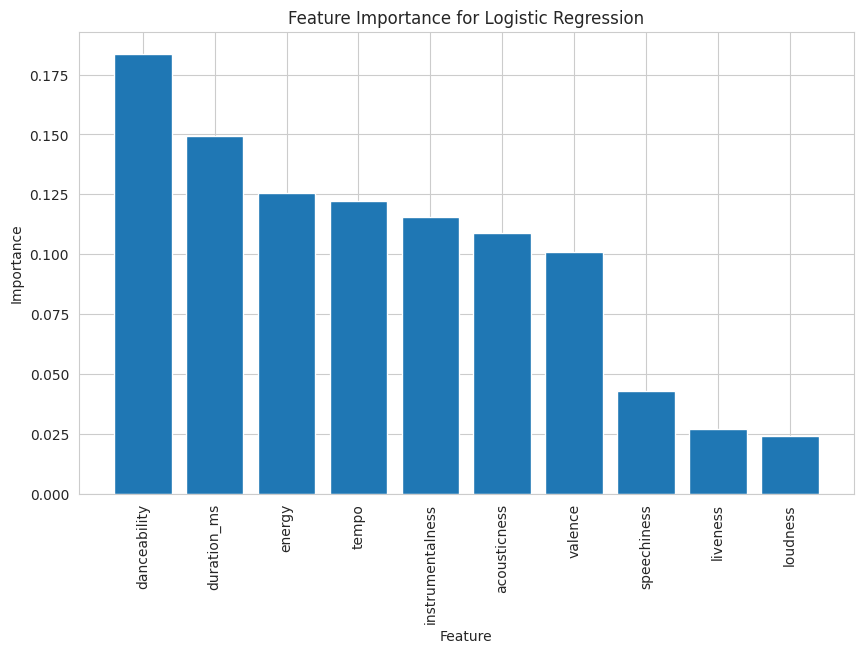

In [ ]:
# Retrieve the coefficients
coefficients = logreg_best.coef_[0]

# Optionally normalize the coefficients
coefficients_normalized = coefficients / np.sum(np.abs(coefficients))

# Rank the features based on coefficient magnitudes
feature_importance = np.abs(coefficients_normalized)
sorted_indices = np.argsort(feature_importance)[::-1]

# Plot feature importance
plt.figure(figsize=(10, 6))
plt.bar(range(len(feature_importance)), feature_importance[sorted_indices], align='center')
plt.xticks(range(len(feature_importance)), [X_train.columns[idx] for idx in sorted_indices], rotation=90)
plt.xlabel('Feature')
plt.ylabel('Importance')
plt.title('Feature Importance for Logistic Regression')
plt.show();

### Decision Tree Model



In [ ]:
criterion = ['gini']
max_dephts = [5, 10, 15]
min_samples_split = [2, 5, 10]
min_samples_leaf = [2, 5, 7]
max_features = ['sqrt', 'log2', None]

dt = DecisionTreeClassifier(random_state=42)

trc = GridSearchCV(estimator=dt,
                   scoring=scoring_dict,
                   param_grid={
                       'criterion': criterion,
                       'max_depth': max_dephts,
                       'min_samples_split': min_samples_split,
                       'min_samples_leaf': min_samples_leaf,
                       'max_features': max_features
                   },
                   cv=4,
                   return_train_score=False,
                   refit='f1_mac')

CV_model = trc.fit(X_train, y_train)

In [ ]:
scoring_cols = [
    'param_criterion', 'param_max_depth', 'param_max_features',
    'param_min_samples_leaf', 'param_min_samples_split', 'mean_test_f1_mac', 'mean_test_acc'
]

pd.DataFrame(CV_model.cv_results_).sort_values(by='mean_test_f1_mac', ascending=False)[scoring_cols].head()

,param_criterion,param_max_depth,param_max_features,param_min_samples_leaf,param_min_samples_split,mean_test_f1_mac,mean_test_acc
80,gini,15,None,7,10,0.777,0.778
79,gini,15,None,7,5,0.777,0.778
78,gini,15,None,7,2,0.777,0.778
77,gini,15,None,5,10,0.777,0.777
76,gini,15,None,5,5,0.777,0.777


In [ ]:
best_params_tree = CV_model.best_params_
best_params_tree

{'criterion': 'gini',
 'max_depth': 15,
 'max_features': None,
 'min_samples_leaf': 7,
 'min_samples_split': 2}

Use the best parameter set to retrain the model and measure the performance.

In [ ]:
dt_best_model = DecisionTreeClassifier(**best_params_tree)
cv_predict(dt_best_model, X_train, y_train)

,Accuracy,Precision,Recall,F1-Score
DecisionTreeClassifier,0.781,0.771,0.781,0.774
QuadraticDiscriminantAnalysis,0.769,0.77,0.768,0.759
KNeighborsClassifier,0.752,0.742,0.75,0.744
GaussianNB,0.735,0.737,0.735,0.72
LogisticRegression,0.722,0.71,0.717,0.711
LinearDiscriminantAnalysis,0.659,0.655,0.655,0.651


In [ ]:
dt_best_model.fit(X_train, y_train)
print(classification_report(y_val, dt_best_model.predict(X_val)))
confusion(y_val, dt_best_model.predict(X_val))

DecisionTreeClassifier(max_depth=15, min_samples_leaf=7)

              precision    recall  f1-score   support

         Emo       0.58      0.68      0.63       316
         Rap       0.57      0.54      0.56       532
         RnB       0.52      0.57      0.54       406
         dnb       0.96      0.95      0.95       584
   hardstyle       0.84      0.84      0.84       596
   psytrance       0.85      0.88      0.86       603
   techhouse       0.86      0.87      0.86       601
      techno       0.79      0.80      0.79       578
      trance       0.85      0.77      0.81       603
        trap       0.82      0.77      0.79       616

    accuracy                           0.78      5435
   macro avg       0.76      0.77      0.76      5435
weighted avg       0.78      0.78      0.78      5435



predicted,Emo,Rap,RnB,dnb,hardstyle,psytrance,techhouse,techno,trance,trap
target,,,,,,,,,,
Emo,216,27,37,8,7,2,4,1,9,5
Rap,35,287,143,10,12,5,4,6,11,19
RnB,51,112,230,4,1,0,4,1,0,3
dnb,18,8,4,554,0,0,0,0,0,0
hardstyle,16,6,3,1,501,2,0,0,0,67
psytrance,1,2,1,0,9,529,3,26,25,7
techhouse,5,18,6,0,0,0,522,44,6,0
techno,0,3,2,0,0,26,60,461,26,0
trance,14,10,10,0,1,44,11,48,463,2


### Random Forest Model


In [ ]:
rf = RandomForestClassifier()

ntrees = [200, 300, 400]
max_depth = [None, 70, 100]
min_samples_split = [4,6]
min_samples_leaf = [4,6,10]
class_weight = [None, 'balanced', 'balanced_subsample']

trc = RandomizedSearchCV(estimator=rf,
                   scoring=scoring_dict,
                   param_distributions={
                       'n_estimators': ntrees,
                       'max_depth':max_depth,
                       'min_samples_split':min_samples_split,
                       'min_samples_leaf':min_samples_leaf,
                       'class_weight': class_weight
                   },
                   cv=4,
                   return_train_score=False,
                   refit=False,
                   n_jobs=-1,
                   n_iter=20,
                   verbose=2,
                   random_state=42)

CV_model_rf = trc.fit(X_train, y_train)

Fitting 4 folds for each of 20 candidates, totalling 80 fits


In [ ]:
scoring_cols = [
    'param_max_depth', 'param_min_samples_leaf', 'param_min_samples_split',
    'mean_test_f1_mac', 'mean_test_acc'
]
pd.DataFrame(CV_model_rf.cv_results_).sort_values(
    by='mean_test_f1_mac', ascending=False)[scoring_cols].head()

,param_max_depth,param_min_samples_leaf,param_min_samples_split,mean_test_f1_mac,mean_test_acc
3,None,4,4,0.855,0.856
9,100,4,4,0.854,0.855
2,70,4,6,0.854,0.855
1,None,4,4,0.854,0.854
4,100,4,6,0.854,0.854


In [ ]:
best_params_rf = pd.DataFrame(CV_model_rf.cv_results_).sort_values(by='mean_test_f1_mac',ascending=False)[['params']].iloc[0,0]
best_params_rf

{'n_estimators': 300,
 'min_samples_split': 4,
 'min_samples_leaf': 4,
 'max_depth': None,
 'class_weight': 'balanced'}

Use the best parameter set to retrain the model and measure the performance.

In [ ]:
rf_best_model = RandomForestClassifier(**best_params_rf, random_state=123)
cv_predict(rf_best_model, X_train, y_train)

,Accuracy,Precision,Recall,F1-Score
RandomForestClassifier,0.855,0.847,0.854,0.849
DecisionTreeClassifier,0.781,0.771,0.781,0.774
QuadraticDiscriminantAnalysis,0.769,0.77,0.768,0.759
KNeighborsClassifier,0.752,0.742,0.75,0.744
GaussianNB,0.735,0.737,0.735,0.72
LogisticRegression,0.722,0.71,0.717,0.711
LinearDiscriminantAnalysis,0.659,0.655,0.655,0.651


In [ ]:
rf_best_model.fit(X_train, y_train)
print(classification_report(y_val, rf_best_model.predict(X_val)))
confusion(y_val, rf_best_model.predict(X_val))

RandomForestClassifier(class_weight='balanced', min_samples_leaf=4,
                       min_samples_split=4, n_estimators=300, random_state=123)

              precision    recall  f1-score   support

         Emo       0.69      0.77      0.73       316
         Rap       0.71      0.65      0.68       532
         RnB       0.64      0.66      0.65       406
         dnb       0.98      0.98      0.98       584
   hardstyle       0.90      0.90      0.90       596
   psytrance       0.90      0.91      0.90       603
   techhouse       0.91      0.92      0.91       601
      techno       0.84      0.86      0.85       578
      trance       0.86      0.86      0.86       603
        trap       0.89      0.84      0.86       616

    accuracy                           0.85      5435
   macro avg       0.83      0.83      0.83      5435
weighted avg       0.85      0.85      0.85      5435



predicted,Emo,Rap,RnB,dnb,hardstyle,psytrance,techhouse,techno,trance,trap
target,,,,,,,,,,
Emo,242,21,31,3,7,1,1,1,7,2
Rap,25,346,103,6,10,2,2,6,12,20
RnB,39,89,269,3,1,0,5,0,0,0
dnb,7,1,2,574,0,0,0,0,0,0
hardstyle,15,2,0,0,537,5,0,0,0,37
psytrance,0,0,1,0,2,547,1,23,22,7
techhouse,2,6,4,0,0,0,553,33,3,0
techno,0,0,0,0,0,17,40,497,24,0
trance,6,3,6,0,0,30,9,32,516,1


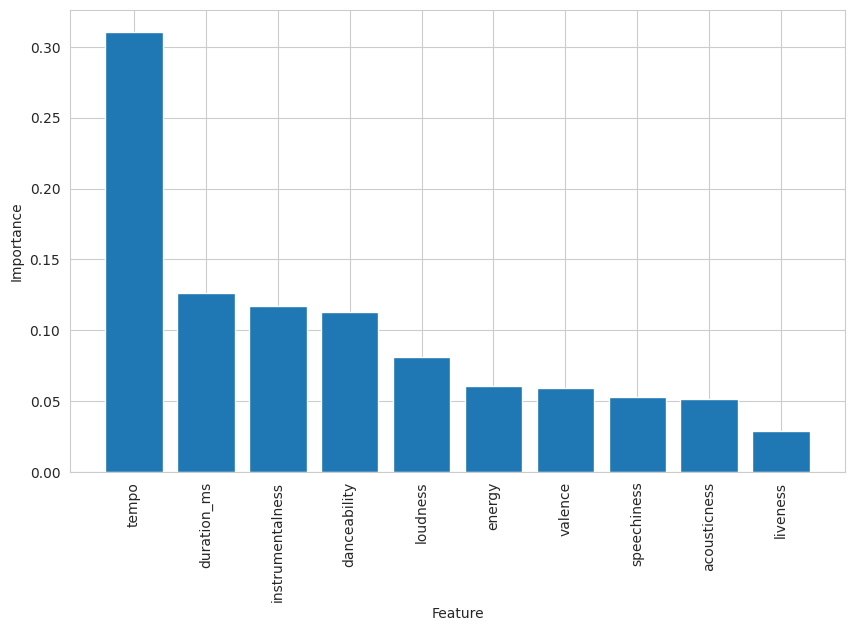

In [ ]:
# Retrieve the coefficients
coefficients = rf_best_model.feature_importances_

# Optionally normalize the coefficients
coefficients_normalized = coefficients / np.sum(np.abs(coefficients))

# Rank the features based on coefficient magnitudes
feature_importance = np.abs(coefficients_normalized)
sorted_indices = np.argsort(feature_importance)[::-1]

# Plot feature importance
plt.figure(figsize=(10, 6))
plt.bar(range(len(feature_importance)), feature_importance[sorted_indices], align='center')
plt.xticks(range(len(feature_importance)), [X_train.columns[idx] for idx in sorted_indices], rotation=90)
plt.xlabel('Feature')
plt.ylabel('Importance')
plt.show();

### Extra Tree Model

In [ ]:
et = ExtraTreesClassifier(random_state=123)

ntrees = [150, 200, 250]
max_depth = [70,100]
min_samples_split = [2, 5, 7]
min_samples_leaf = [2, 4]
class_weight = [None, 'balanced', 'balanced_subsample']

trc = RandomizedSearchCV(estimator=et,
                   scoring=scoring_dict,
                   param_distributions={
                       'n_estimators': ntrees,
                       'max_depth': max_depth,
                       'min_samples_split': min_samples_split,
                       'min_samples_leaf': min_samples_leaf,
                       'class_weight': class_weight
                   },
                   cv=4,
                   return_train_score=True,
                   refit=False,
                   n_jobs=-1,
                   n_iter=20,
                   random_state=42,
                   verbose=2)

CV_model_et = trc.fit(X_train, y_train)

Fitting 4 folds for each of 20 candidates, totalling 80 fits


In [ ]:
pd.DataFrame(CV_model_et.cv_results_).sort_values(by='mean_test_f1_mac',ascending=False)[scoring_cols].head()

,param_max_depth,param_min_samples_leaf,param_min_samples_split,mean_test_f1_mac,mean_test_acc
14,100,2,2,0.852,0.853
12,70,2,2,0.852,0.853
0,70,2,5,0.852,0.852
8,100,2,5,0.852,0.852
2,70,2,5,0.852,0.852


In [ ]:
best_params_et = pd.DataFrame(CV_model_et.cv_results_).sort_values(by='mean_test_f1_mac',ascending=False)[['params']].iloc[0,0]
best_params_et

{'n_estimators': 150,
 'min_samples_split': 2,
 'min_samples_leaf': 2,
 'max_depth': 100,
 'class_weight': None}

Use the best parameter set to retrain the model and measure the performance.

In [ ]:
et_best_model = ExtraTreesClassifier(**best_params_et, random_state=123)
cv_predict(et_best_model, X_train, y_train)

,Accuracy,Precision,Recall,F1-Score
RandomForestClassifier,0.855,0.847,0.854,0.849
ExtraTreesClassifier,0.851,0.842,0.848,0.844
DecisionTreeClassifier,0.781,0.771,0.781,0.774
QuadraticDiscriminantAnalysis,0.769,0.77,0.768,0.759
KNeighborsClassifier,0.752,0.742,0.75,0.744
GaussianNB,0.735,0.737,0.735,0.72
LogisticRegression,0.722,0.71,0.717,0.711
LinearDiscriminantAnalysis,0.659,0.655,0.655,0.651


In [ ]:
et_best_model.fit(X_train, y_train)
print(classification_report(y_val, et_best_model.predict(X_val)))
confusion(y_val, et_best_model.predict(X_val))

ExtraTreesClassifier(max_depth=100, min_samples_leaf=2, n_estimators=150,
                     random_state=123)

              precision    recall  f1-score   support

         Emo       0.72      0.76      0.74       316
         Rap       0.71      0.64      0.67       532
         RnB       0.64      0.67      0.65       406
         dnb       0.97      0.98      0.97       584
   hardstyle       0.89      0.91      0.90       596
   psytrance       0.91      0.91      0.91       603
   techhouse       0.88      0.90      0.89       601
      techno       0.82      0.87      0.84       578
      trance       0.83      0.85      0.84       603
        trap       0.91      0.82      0.86       616

    accuracy                           0.84      5435
   macro avg       0.83      0.83      0.83      5435
weighted avg       0.84      0.84      0.84      5435



predicted,Emo,Rap,RnB,dnb,hardstyle,psytrance,techhouse,techno,trance,trap
target,,,,,,,,,,
Emo,241,15,37,4,8,0,2,1,8,0
Rap,17,341,99,12,10,1,7,6,22,17
RnB,38,90,273,1,0,0,4,0,0,0
dnb,6,5,2,571,0,0,0,0,0,0
hardstyle,13,2,0,0,545,6,0,0,0,30
psytrance,0,0,0,0,2,546,2,24,25,4
techhouse,2,7,5,0,0,0,538,40,8,1
techno,0,0,0,0,0,15,41,500,22,0
trance,7,2,4,0,0,28,13,36,512,1


### Multi-class SVM

In [ ]:
svc_model = SVC(kernel='linear', decision_function_shape='ovr')
cv_predict(svc_model, X_train, y_train)

,Accuracy,Precision,Recall,F1-Score
RandomForestClassifier,0.855,0.847,0.854,0.849
ExtraTreesClassifier,0.851,0.842,0.848,0.844
DecisionTreeClassifier,0.781,0.771,0.781,0.774
QuadraticDiscriminantAnalysis,0.769,0.77,0.768,0.759
SVC,0.761,0.759,0.758,0.754
KNeighborsClassifier,0.752,0.742,0.75,0.744
GaussianNB,0.735,0.737,0.735,0.72
LogisticRegression,0.722,0.71,0.717,0.711
LinearDiscriminantAnalysis,0.659,0.655,0.655,0.651


We try some parameter sets for the SVM to find the best performing combination.

In [ ]:
c_value = [0.1, 1]
gamma = [0.01, 0.1, 1]
kernel = ['rbf', 'poly']

param_grid = {
    'C': c_value,
    'gamma': gamma,
    'kernel': kernel
}

grid = RandomizedSearchCV(estimator=SVC(),
                   param_distributions=param_grid,
                   cv=4,
                   return_train_score=True,
                   refit=False,
                   n_jobs=-1,
                   n_iter = 5,
                   random_state=42,
                   verbose=2)
grid.fit(X_train, y_train)

Fitting 4 folds for each of 5 candidates, totalling 20 fits


RandomizedSearchCV(cv=4, estimator=SVC(), n_iter=5, n_jobs=-1,
                   param_distributions={'C': [0.1, 1], 'gamma': [0.01, 0.1, 1],
                                        'kernel': ['rbf', 'poly']},
                   random_state=42, refit=False, return_train_score=True,
                   verbose=2)

In [ ]:
# Get best parameters
best_params = grid.best_params_
print("Best parameters:", best_params)

Best parameters: {'kernel': 'rbf', 'gamma': 1, 'C': 1}


Use the best parameter set to retrain the model and measure the performance.

In [ ]:
svc_best = SVC(probability=True,**best_params)
cv_predict(svc_best, X_train, y_train)

,Accuracy,Precision,Recall,F1-Score
XGBClassifier,0.862,0.855,0.861,0.857
RandomForestClassifier,0.855,0.847,0.854,0.849
ExtraTreesClassifier,0.851,0.842,0.848,0.844
VotingClassifier,0.841,0.833,0.838,0.834
MLPClassifier,0.794,0.784,0.793,0.787
SVC,0.786,0.78,0.784,0.779
DecisionTreeClassifier,0.781,0.771,0.781,0.774
QuadraticDiscriminantAnalysis,0.769,0.77,0.768,0.759
KNeighborsClassifier,0.752,0.742,0.75,0.744
GaussianNB,0.735,0.737,0.735,0.72


In [ ]:
svc_best.fit(X_train, y_train)
print(classification_report(y_val, svc_best.predict(X_val)))
confusion(y_val, svc_best.predict(X_val))

SVC(C=1, gamma=1, probability=True)

              precision    recall  f1-score   support

         Emo       0.50      0.72      0.59       316
         Rap       0.70      0.62      0.66       532
         RnB       0.60      0.64      0.62       406
         dnb       0.97      0.90      0.93       584
   hardstyle       0.83      0.78      0.81       596
   psytrance       0.86      0.89      0.87       603
   techhouse       0.83      0.84      0.84       601
      techno       0.80      0.83      0.82       578
      trance       0.77      0.78      0.78       603
        trap       0.87      0.74      0.80       616

    accuracy                           0.78      5435
   macro avg       0.77      0.77      0.77      5435
weighted avg       0.79      0.78      0.79      5435



predicted,Emo,Rap,RnB,dnb,hardstyle,psytrance,techhouse,techno,trance,trap
target,,,,,,,,,,
Emo,228,13,40,7,13,1,3,0,11,0
Rap,25,331,99,8,14,2,14,6,19,14
RnB,53,75,258,3,1,0,15,0,1,0
dnb,40,10,11,523,0,0,0,0,0,0
hardstyle,58,3,2,0,467,13,0,0,2,51
psytrance,0,1,1,0,1,535,3,27,30,5
techhouse,3,13,6,0,0,0,505,53,21,0
techno,0,0,1,0,0,17,47,481,32,0
trance,24,7,2,0,0,49,17,31,472,1


### Neural Networks

In [ ]:
nnet_model = MLPClassifier(hidden_layer_sizes=[70,110],
                           alpha=0.01,
                           activation='relu',
                           max_iter = 400,
                           early_stopping = True,
                           solver='adam',random_state=123)
cv_predict(nnet_model, X_train, y_train)

,Accuracy,Precision,Recall,F1-Score
RandomForestClassifier,0.855,0.847,0.854,0.849
ExtraTreesClassifier,0.851,0.842,0.848,0.844
MLPClassifier,0.807,0.799,0.806,0.801
SVC,0.786,0.78,0.784,0.779
DecisionTreeClassifier,0.781,0.771,0.781,0.774
QuadraticDiscriminantAnalysis,0.769,0.77,0.768,0.759
KNeighborsClassifier,0.752,0.742,0.75,0.744
GaussianNB,0.735,0.737,0.735,0.72
LogisticRegression,0.722,0.71,0.717,0.711
LinearDiscriminantAnalysis,0.659,0.655,0.655,0.651


In [ ]:
nnet_model.fit(X_train, y_train)
coefficients = nnet_model.coefs_[0]
nnet_model.intercepts_

MLPClassifier(alpha=0.01, early_stopping=True, hidden_layer_sizes=[70, 110],
              max_iter=400, random_state=123)

[array([ 4.29840388e-01,  1.29822965e-01, -1.37316303e-01, -3.49760071e-01,
         2.71841274e-01, -4.22192890e-01,  2.97924424e-01,  6.03886610e-01,
        -2.13119605e-01, -1.40732611e-01,  4.22647347e-01,  1.14917798e-01,
         3.69402411e-01, -1.96516854e-01,  3.48403910e-01, -7.39374244e-02,
        -2.29371745e-01,  5.15504990e-02, -3.73173340e-01, -5.34158852e-01,
        -5.67672829e-02, -5.69957353e-02,  3.91159995e-01, -1.50299150e-01,
        -1.49593703e-01,  1.85469041e-01, -1.12547678e-01,  3.36282424e-01,
        -3.49701543e-01, -2.35530455e-01,  3.23111778e-01,  2.70052579e-01,
        -6.00130610e-02,  1.92896373e-01,  1.69280215e-01,  5.16977395e-01,
         1.58187641e-01, -7.43530788e-02,  6.76864816e-02,  3.88282518e-01,
         2.40716741e-01,  1.35381803e-01, -1.44599741e-01, -6.53403436e-02,
         2.96890054e-01,  3.12495469e-02,  3.58538335e-01,  3.71348927e-01,
         3.36653132e-01,  3.74588454e-01, -1.44838976e-01,  2.16976149e-01,
        -1.7

In [ ]:
sizes = [
    [128],
    [64, 64],
    [32, 64, 32],
    [128, 128],
    [256],
    [128, 256],
    [64, 128, 64],
    [32, 64, 128, 64],
    [256, 256],
    [70,110]
]
decays = [0.0001,0.001,0.01,0.1,1]
activation = ['relu','logistic']

param_grid={
    'hidden_layer_sizes': sizes,
    'alpha': decays,
    'activation':activation
}

model_nnet_tune = MLPClassifier(alpha=0,
                           max_iter=400,
                           solver='adam',
                           random_state=42)

trc = RandomizedSearchCV(estimator=model_nnet_tune,
                   scoring=['f1_macro', 'accuracy'],
                   param_distributions=param_grid,
                   cv=3,
                   return_train_score=True,
                   refit='f1_macro',
                   random_state=42,
                   verbose=2,
                   n_iter = 10)

model_5CV = trc.fit(X_train, y_train)

Fitting 3 folds for each of 10 candidates, totalling 30 fits
[CV] END activation=logistic, alpha=0.1, hidden_layer_sizes=[128, 128]; total time= 2.1min
[CV] END activation=logistic, alpha=0.1, hidden_layer_sizes=[128, 128]; total time= 1.6min
[CV] END activation=logistic, alpha=0.1, hidden_layer_sizes=[128, 128]; total time= 1.8min
[CV] END activation=logistic, alpha=0.0001, hidden_layer_sizes=[128, 128]; total time= 2.0min
[CV] END activation=logistic, alpha=0.0001, hidden_layer_sizes=[128, 128]; total time= 2.0min
[CV] END activation=logistic, alpha=0.0001, hidden_layer_sizes=[128, 128]; total time= 2.0min
[CV] END activation=logistic, alpha=0.01, hidden_layer_sizes=[128]; total time=  32.0s
[CV] END activation=logistic, alpha=0.01, hidden_layer_sizes=[128]; total time=  30.7s
[CV] END activation=logistic, alpha=0.01, hidden_layer_sizes=[128]; total time=  31.3s
[CV] END activation=relu, alpha=1, hidden_layer_sizes=[128, 256]; total time=  51.8s
[CV] END activation=relu, alpha=1, hid

In [ ]:
best_params_mlp = model_5CV.best_params_
best_params_mlp

{'hidden_layer_sizes': [128], 'alpha': 0.0001, 'activation': 'relu'}

In [ ]:
nnet_best = MLPClassifier(**best_params_mlp)
cv_predict(nnet_best, X_train, y_train)

,Accuracy,Precision,Recall,F1-Score
RandomForestClassifier,0.855,0.847,0.854,0.849
ExtraTreesClassifier,0.851,0.842,0.848,0.844
MLPClassifier,0.815,0.806,0.813,0.808
SVC,0.786,0.78,0.784,0.779
DecisionTreeClassifier,0.781,0.771,0.781,0.774
QuadraticDiscriminantAnalysis,0.769,0.77,0.768,0.759
KNeighborsClassifier,0.752,0.742,0.75,0.744
GaussianNB,0.735,0.737,0.735,0.72
LogisticRegression,0.722,0.71,0.717,0.711
LinearDiscriminantAnalysis,0.659,0.655,0.655,0.651


In [ ]:
nnet_best.fit(X_train, y_train)
print(classification_report(y_val, nnet_best.predict(X_val)))
confusion(y_val, nnet_best.predict(X_val))

MLPClassifier(hidden_layer_sizes=[128])

              precision    recall  f1-score   support

         Emo       0.68      0.72      0.70       316
         Rap       0.71      0.64      0.67       532
         RnB       0.63      0.67      0.65       406
         dnb       0.98      0.95      0.96       584
   hardstyle       0.83      0.91      0.87       596
   psytrance       0.88      0.89      0.89       603
   techhouse       0.87      0.86      0.87       601
      techno       0.80      0.87      0.83       578
      trance       0.82      0.83      0.82       603
        trap       0.89      0.77      0.83       616

    accuracy                           0.82      5435
   macro avg       0.81      0.81      0.81      5435
weighted avg       0.82      0.82      0.82      5435



predicted,Emo,Rap,RnB,dnb,hardstyle,psytrance,techhouse,techno,trance,trap
target,,,,,,,,,,
Emo,228,16,40,5,12,1,4,1,8,1
Rap,16,338,101,7,14,1,13,6,18,18
RnB,39,79,274,1,1,0,10,0,1,1
dnb,17,6,4,556,0,1,0,0,0,0
hardstyle,15,3,0,0,541,9,0,0,0,28
psytrance,0,1,1,0,3,538,0,26,27,7
techhouse,2,13,5,0,0,0,516,53,12,0
techno,0,0,0,0,0,14,36,503,25,0
trance,7,5,3,0,0,36,12,39,500,1


PCA for Neural Network

In [ ]:
pca = PCA().fit(X_train)

n_components =(pca.explained_variance_ratio_.cumsum() < 0.99).sum()
n_components

8

In [ ]:
pca = PCA(n_components=n_components).fit(X_train)

X_train_pca = pca.transform(X_train)

In [ ]:
nnet_pca = MLPClassifier(**best_params_mlp)

cv_predict(nnet_pca, X_train_pca, y_train)

,Accuracy,Precision,Recall,F1-Score
RandomForestClassifier,0.855,0.847,0.854,0.849
ExtraTreesClassifier,0.851,0.842,0.848,0.844
MLPClassifier,0.794,0.784,0.793,0.787
SVC,0.786,0.78,0.784,0.779
DecisionTreeClassifier,0.781,0.771,0.781,0.774
QuadraticDiscriminantAnalysis,0.769,0.77,0.768,0.759
KNeighborsClassifier,0.752,0.742,0.75,0.744
GaussianNB,0.735,0.737,0.735,0.72
LogisticRegression,0.722,0.71,0.717,0.711
LinearDiscriminantAnalysis,0.659,0.655,0.655,0.651


### XGBoost CLassifier

In [ ]:
le = LabelEncoder()
y_train_encoded = le.fit_transform(y_train)
y_val_encoded = le.fit_transform(y_val)

In [ ]:
xgb_model = XGBClassifier(use_label_encoder=False, eval_metric='mlogloss')
cv_predict(xgb_model, X_train, y_train_encoded)

,Accuracy,Precision,Recall,F1-Score
XGBClassifier,0.862,0.855,0.861,0.858
RandomForestClassifier,0.855,0.847,0.854,0.849
ExtraTreesClassifier,0.851,0.842,0.848,0.844
MLPClassifier,0.794,0.784,0.793,0.787
SVC,0.786,0.78,0.784,0.779
DecisionTreeClassifier,0.781,0.771,0.781,0.774
QuadraticDiscriminantAnalysis,0.769,0.77,0.768,0.759
KNeighborsClassifier,0.752,0.742,0.75,0.744
GaussianNB,0.735,0.737,0.735,0.72
LogisticRegression,0.722,0.71,0.717,0.711


In [ ]:
n_estimators = [300, 400, 500]
max_depth = [3,5]
learning_rate = [0.05,0.1, 0.01]
min_child_weight = [2, 4, 6]
subsample = [0.8,0.9]

param_grid = {
    'n_estimators': n_estimators,
    'max_depth': max_depth,
    'learning_rate': learning_rate,
    'min_child_weight': min_child_weight,
    'subsample': subsample
}

trc = RandomizedSearchCV(estimator=XGBClassifier(use_label_encoder=False, eval_metric='mlogloss', seed=42),
                    param_distributions=param_grid,
                    cv=5,
                    return_train_score=True,
                    refit=False,
                    n_jobs=-1,
                    n_iter=10,
                    verbose=2)
xgb = trc.fit(X_train, y_train_encoded)

Fitting 5 folds for each of 10 candidates, totalling 50 fits


In [ ]:
xgb.best_params_

{'subsample': 0.8,
 'n_estimators': 400,
 'min_child_weight': 4,
 'max_depth': 5,
 'learning_rate': 0.05}

In [ ]:
xgb_best = XGBClassifier(use_label_encoder=False,**xgb.best_params_)
cv_predict(xgb_best, X_train, y_train_encoded)

,Accuracy,Precision,Recall,F1-Score
XGBClassifier,0.862,0.855,0.861,0.857
RandomForestClassifier,0.855,0.847,0.854,0.849
ExtraTreesClassifier,0.851,0.842,0.848,0.844
MLPClassifier,0.794,0.784,0.793,0.787
SVC,0.786,0.78,0.784,0.779
DecisionTreeClassifier,0.781,0.771,0.781,0.774
QuadraticDiscriminantAnalysis,0.769,0.77,0.768,0.759
KNeighborsClassifier,0.752,0.742,0.75,0.744
GaussianNB,0.735,0.737,0.735,0.72
LogisticRegression,0.722,0.71,0.717,0.711


In [ ]:
xgb_best.fit(X_train, y_train_encoded)

y_pred_val_encoded=xgb_best.predict(X_val)

y_val_labels = le.inverse_transform(y_val_encoded)
y_pred_val_labels = le.inverse_transform(y_pred_val_encoded)

print(classification_report(y_val_labels, y_pred_val_labels))
confusion(y_val_labels, y_pred_val_labels, True)

XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, device=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric=None, feature_types=None,
              gamma=None, grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=0.05, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=5, max_leaves=None,
              min_child_weight=4, missing=nan, monotone_constraints=None,
              multi_strategy=None, n_estimators=400, n_jobs=None,
              num_parallel_tree=None, objective='multi:softprob', ...)

              precision    recall  f1-score   support

         Emo       0.76      0.77      0.76       316
         Rap       0.73      0.65      0.69       532
         RnB       0.63      0.70      0.66       406
         dnb       0.98      0.99      0.99       584
   hardstyle       0.91      0.93      0.92       596
   psytrance       0.91      0.91      0.91       603
   techhouse       0.90      0.93      0.91       601
      techno       0.84      0.86      0.85       578
      trance       0.87      0.86      0.87       603
        trap       0.90      0.87      0.88       616

    accuracy                           0.86      5435
   macro avg       0.84      0.85      0.84      5435
weighted avg       0.86      0.86      0.86      5435



predicted,Emo,Rap,RnB,dnb,hardstyle,psytrance,techhouse,techno,trance,trap
target,,,,,,,,,,
Emo,242,17,39,2,6,0,2,1,5,2
Rap,17,348,110,5,9,4,5,3,12,19
RnB,34,81,283,4,1,0,2,0,1,0
dnb,4,0,2,578,0,0,0,0,0,0
hardstyle,8,4,0,0,554,2,0,0,0,28
psytrance,0,1,1,0,1,548,0,24,20,8
techhouse,1,4,4,0,0,0,556,31,5,0
techno,0,1,0,0,0,11,43,498,25,0
trance,3,5,3,0,0,28,8,38,517,1


XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, device=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric=None, feature_types=None,
              gamma=None, grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=0.05, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=5, max_leaves=None,
              min_child_weight=4, missing=nan, monotone_constraints=None,
              multi_strategy=None, n_estimators=400, n_jobs=None,
              num_parallel_tree=None, objective='multi:softprob', ...)

<Axes: title={'center': 'Feature importance'}, xlabel='F score', ylabel='Features'>

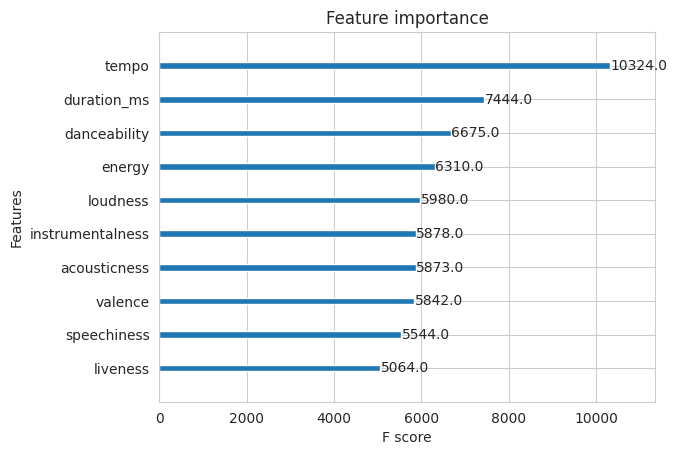

In [ ]:
import xgboost as xgb

# Plot feature importance
xgb_best.fit(X_train, y_train_encoded)
xgb.plot_importance(xgb_best)
plt.show()


### Ensembles Methods

We now have a list of some modelling methods and their performance. Now we combine the best performing models in ensembles methods.

#### Voting Classifier

Hard voting


In [ ]:
voting_hard = VotingClassifier([('xgb', xgb_best), ('et', et_best_model),
                                ('nnet', nnet_best),('svm',svc_best)], voting='hard')
cv_predict(voting_hard, X_train, y_train)

,Accuracy,Precision,Recall,F1-Score
XGBClassifier,0.862,0.855,0.861,0.857
RandomForestClassifier,0.855,0.847,0.854,0.849
ExtraTreesClassifier,0.851,0.842,0.848,0.844
VotingClassifier,0.841,0.833,0.838,0.834
MLPClassifier,0.794,0.784,0.793,0.787
SVC,0.786,0.78,0.784,0.779
DecisionTreeClassifier,0.781,0.771,0.781,0.774
QuadraticDiscriminantAnalysis,0.769,0.77,0.768,0.759
KNeighborsClassifier,0.752,0.742,0.75,0.744
GaussianNB,0.735,0.737,0.735,0.72


In [ ]:
voting_hard.fit(X_train, y_train)
print(classification_report(y_val, voting_hard.predict(X_val)))
confusion(y_val, voting_hard.predict(X_val))

VotingClassifier(estimators=[('xgb',
                              XGBClassifier(base_score=None, booster=None,
                                            callbacks=None,
                                            colsample_bylevel=None,
                                            colsample_bynode=None,
                                            colsample_bytree=None, device=None,
                                            early_stopping_rounds=None,
                                            enable_categorical=False,
                                            eval_metric=None,
                                            feature_types=None, gamma=None,
                                            grow_policy=None,
                                            importance_type=None,
                                            interaction_constraints=None,
                                            learning_ra...
                                            max_delta_step=None, max_depth=5,
                                            max_leaves=None, min_child_weight=4,
                                            missing=nan,
                                            monotone_constraints=None,
                                            multi_strategy=None,
                                            n_estimators=400, n_jobs=None,
                                            num_parallel_tree=None,
                                            objective='multi:softprob', ...)),
                             ('et',
                              ExtraTreesClassifier(max_depth=100,
                                                   min_samples_leaf=2,
                                                   n_estimators=150,
                                                   random_state=123)),
                             ('nnet', MLPClassifier(hidden_layer_sizes=[128])),
                             ('svm', SVC(C=1, gamma=1))])

              precision    recall  f1-score   support

         Emo       0.63      0.79      0.70       316
         Rap       0.71      0.68      0.70       532
         RnB       0.65      0.64      0.64       406
         dnb       0.98      0.96      0.97       584
   hardstyle       0.88      0.91      0.89       596
   psytrance       0.88      0.93      0.90       603
   techhouse       0.88      0.90      0.89       601
      techno       0.85      0.85      0.85       578
      trance       0.84      0.81      0.82       603
        trap       0.91      0.79      0.84       616

    accuracy                           0.84      5435
   macro avg       0.82      0.83      0.82      5435
weighted avg       0.84      0.84      0.84      5435



predicted,Emo,Rap,RnB,dnb,hardstyle,psytrance,techhouse,techno,trance,trap
target,,,,,,,,,,
Emo,251,15,34,2,7,1,1,1,4,0
Rap,24,363,84,6,11,2,7,5,16,14
RnB,52,88,259,1,1,0,4,0,1,0
dnb,16,5,3,560,0,0,0,0,0,0
hardstyle,19,4,0,0,541,5,0,0,0,27
psytrance,0,0,1,0,1,559,1,17,18,6
techhouse,2,11,5,0,0,0,542,33,8,0
techno,0,0,0,0,0,16,45,494,23,0
trance,13,5,3,0,0,46,15,34,486,1


Soft voting


In [ ]:
voting_soft = VotingClassifier([('xgb', xgb_best), ('et', et_best_model),
                                ('nnet', nnet_best),('svm',svc_best)], voting='soft')
cv_predict(voting_soft, X_train, y_train)

,Accuracy,Precision,Recall,F1-Score
XGBClassifier,0.862,0.855,0.861,0.857
RandomForestClassifier,0.855,0.847,0.854,0.849
VotingClassifier,0.85,0.843,0.849,0.845
ExtraTreesClassifier,0.851,0.842,0.848,0.844
MLPClassifier,0.794,0.784,0.793,0.787
SVC,0.786,0.78,0.784,0.779
DecisionTreeClassifier,0.781,0.771,0.781,0.774
QuadraticDiscriminantAnalysis,0.769,0.77,0.768,0.759
KNeighborsClassifier,0.752,0.742,0.75,0.744
GaussianNB,0.735,0.737,0.735,0.72


In [ ]:
voting_soft.fit(X_train, y_train)
print(classification_report(y_val, voting_soft.predict(X_val)))
confusion(y_val, voting_soft.predict(X_val))

VotingClassifier(estimators=[('xgb',
                              XGBClassifier(base_score=None, booster=None,
                                            callbacks=None,
                                            colsample_bylevel=None,
                                            colsample_bynode=None,
                                            colsample_bytree=None, device=None,
                                            early_stopping_rounds=None,
                                            enable_categorical=False,
                                            eval_metric=None,
                                            feature_types=None, gamma=None,
                                            grow_policy=None,
                                            importance_type=None,
                                            interaction_constraints=None,
                                            learning_ra...
                                            max_leaves=None, min_child_weight=4,
                                            missing=nan,
                                            monotone_constraints=None,
                                            multi_strategy=None,
                                            n_estimators=400, n_jobs=None,
                                            num_parallel_tree=None,
                                            objective='multi:softprob', ...)),
                             ('et',
                              ExtraTreesClassifier(max_depth=100,
                                                   min_samples_leaf=2,
                                                   n_estimators=150,
                                                   random_state=123)),
                             ('nnet', MLPClassifier(hidden_layer_sizes=[128])),
                             ('svm', SVC(C=1, gamma=1, probability=True))],
                 voting='soft')

              precision    recall  f1-score   support

         Emo       0.68      0.77      0.72       316
         Rap       0.74      0.66      0.70       532
         RnB       0.65      0.68      0.66       406
         dnb       0.98      0.97      0.98       584
   hardstyle       0.89      0.91      0.90       596
   psytrance       0.90      0.91      0.90       603
   techhouse       0.88      0.91      0.89       601
      techno       0.84      0.86      0.85       578
      trance       0.84      0.85      0.84       603
        trap       0.90      0.83      0.87       616

    accuracy                           0.85      5435
   macro avg       0.83      0.83      0.83      5435
weighted avg       0.85      0.85      0.85      5435



predicted,Emo,Rap,RnB,dnb,hardstyle,psytrance,techhouse,techno,trance,trap
target,,,,,,,,,,
Emo,242,15,39,4,7,1,2,0,6,0
Rap,23,353,95,4,12,2,7,5,16,15
RnB,41,76,277,2,1,0,8,0,1,0
dnb,8,5,2,569,0,0,0,0,0,0
hardstyle,14,3,0,0,544,4,0,0,0,31
psytrance,0,0,1,0,1,546,1,21,25,8
techhouse,2,6,5,0,0,0,545,38,5,0
techno,0,0,0,0,0,13,43,495,27,0
trance,9,4,2,0,0,33,11,33,510,1


#### Stacking

In [ ]:
stack_model = StackingClassifier(
    estimators=[('xgb', xgb_best), ('et', et_best_model)],
    final_estimator=GradientBoostingClassifier(random_state=123))
cv_predict(stack_model, X_train, y_train)

,Accuracy,Precision,Recall,F1-Score
XGBClassifier,0.862,0.855,0.861,0.857
StackingClassifier,0.859,0.851,0.857,0.853
RandomForestClassifier,0.855,0.847,0.854,0.849
VotingClassifier,0.85,0.843,0.849,0.845
ExtraTreesClassifier,0.851,0.842,0.848,0.844
MLPClassifier,0.794,0.784,0.793,0.787
SVC,0.786,0.78,0.784,0.779
DecisionTreeClassifier,0.781,0.771,0.781,0.774
QuadraticDiscriminantAnalysis,0.769,0.77,0.768,0.759
KNeighborsClassifier,0.752,0.742,0.75,0.744


In [ ]:
stack_model.fit(X_train, y_train)
print(classification_report(y_val, stack_model.predict(X_val)))
confusion(y_val, stack_model.predict(X_val))

StackingClassifier(estimators=[('xgb',
                                XGBClassifier(base_score=None, booster=None,
                                              callbacks=None,
                                              colsample_bylevel=None,
                                              colsample_bynode=None,
                                              colsample_bytree=None,
                                              device=None,
                                              early_stopping_rounds=None,
                                              enable_categorical=False,
                                              eval_metric=None,
                                              feature_types=None, gamma=None,
                                              grow_policy=None,
                                              importance_type=None,
                                              interaction_constraints=None,
                                              learning_...
                                              max_delta_step=None, max_depth=5,
                                              max_leaves=None,
                                              min_child_weight=4, missing=nan,
                                              monotone_constraints=None,
                                              multi_strategy=None,
                                              n_estimators=400, n_jobs=None,
                                              num_parallel_tree=None,
                                              objective='multi:softprob', ...)),
                               ('et',
                                ExtraTreesClassifier(max_depth=100,
                                                     min_samples_leaf=2,
                                                     n_estimators=150,
                                                     random_state=123))],
                   final_estimator=GradientBoostingClassifier(random_state=123))

              precision    recall  f1-score   support

         Emo       0.73      0.79      0.76       316
         Rap       0.70      0.67      0.68       532
         RnB       0.64      0.64      0.64       406
         dnb       0.98      0.98      0.98       584
   hardstyle       0.91      0.93      0.92       596
   psytrance       0.90      0.90      0.90       603
   techhouse       0.90      0.91      0.90       601
      techno       0.84      0.85      0.84       578
      trance       0.88      0.87      0.87       603
        trap       0.90      0.87      0.88       616

    accuracy                           0.85      5435
   macro avg       0.84      0.84      0.84      5435
weighted avg       0.85      0.85      0.85      5435



predicted,Emo,Rap,RnB,dnb,hardstyle,psytrance,techhouse,techno,trance,trap
target,,,,,,,,,,
Emo,250,16,32,3,7,0,1,0,4,3
Rap,20,355,101,7,5,6,4,4,12,18
RnB,39,101,261,2,0,0,3,0,0,0
dnb,4,5,0,575,0,0,0,0,0,0
hardstyle,12,2,0,0,552,2,0,0,0,28
psytrance,0,0,0,0,3,543,1,23,22,11
techhouse,1,6,5,0,0,0,546,38,5,0
techno,0,0,0,0,0,16,43,491,27,1
trance,3,6,2,0,1,27,9,31,523,1


#### Bagging

In [ ]:
bagging = BaggingClassifier(base_estimator=xgb_best, n_estimators=10, random_state=42)
cv_predict(bagging, X_train, y_train)

,Accuracy,Precision,Recall,F1-Score
XGBClassifier,0.862,0.855,0.861,0.857
BaggingClassifier,0.862,0.854,0.861,0.857
StackingClassifier,0.859,0.851,0.857,0.853
RandomForestClassifier,0.855,0.847,0.854,0.849
VotingClassifier,0.85,0.843,0.849,0.845
ExtraTreesClassifier,0.851,0.842,0.848,0.844
MLPClassifier,0.794,0.784,0.793,0.787
SVC,0.786,0.78,0.784,0.779
DecisionTreeClassifier,0.781,0.771,0.781,0.774
QuadraticDiscriminantAnalysis,0.769,0.77,0.768,0.759


In [ ]:
bagging.fit(X_train, y_train)
print(classification_report(y_val, bagging.predict(X_val)))
confusion(y_val, bagging.predict(X_val))

BaggingClassifier(base_estimator=XGBClassifier(base_score=None, booster=None,
                                               callbacks=None,
                                               colsample_bylevel=None,
                                               colsample_bynode=None,
                                               colsample_bytree=None,
                                               device=None,
                                               early_stopping_rounds=None,
                                               enable_categorical=False,
                                               eval_metric=None,
                                               feature_types=None, gamma=None,
                                               grow_policy=None,
                                               importance_type=None,
                                               interaction_constraints=None,
                                               learning_rate=0.05, max_bin=None,
                                               max_cat_threshold=None,
                                               max_cat_to_onehot=None,
                                               max_delta_step=None, max_depth=5,
                                               max_leaves=None,
                                               min_child_weight=4, missing=nan,
                                               monotone_constraints=None,
                                               multi_strategy=None,
                                               n_estimators=400, n_jobs=None,
                                               num_parallel_tree=None,
                                               objective='multi:softprob', ...),
                  random_state=42)

              precision    recall  f1-score   support

         Emo       0.75      0.78      0.76       316
         Rap       0.74      0.66      0.69       532
         RnB       0.63      0.68      0.66       406
         dnb       0.98      0.99      0.99       584
   hardstyle       0.91      0.94      0.92       596
   psytrance       0.91      0.91      0.91       603
   techhouse       0.91      0.93      0.92       601
      techno       0.85      0.86      0.86       578
      trance       0.86      0.87      0.86       603
        trap       0.91      0.87      0.89       616

    accuracy                           0.86      5435
   macro avg       0.85      0.85      0.85      5435
weighted avg       0.86      0.86      0.86      5435



predicted,Emo,Rap,RnB,dnb,hardstyle,psytrance,techhouse,techno,trance,trap
target,,,,,,,,,,
Emo,246,15,36,1,6,0,2,0,8,2
Rap,18,349,111,4,9,5,3,2,13,18
RnB,38,82,278,4,1,0,2,0,1,0
dnb,4,0,2,578,0,0,0,0,0,0
hardstyle,8,4,0,0,558,2,0,0,0,24
psytrance,0,1,1,0,1,549,0,21,22,8
techhouse,1,6,4,0,0,0,559,26,5,0
techno,0,0,0,0,0,15,42,497,24,0
trance,3,3,2,0,0,27,9,36,522,1


## Model selection

After training our last model, we can now take a look and examine the results. It seems like XGBoost has the best results in terms of F1-score, followed by the Bagging Classifies, as it has the XGBoost model as base. Random Forest is close to XGBoost with an F1-score of 0.849. All in all the first 6 models have really similar results, and LDA has the poorest performance. We can definitely say that grouping together some genres really helped to get better results, as before the grouping our best F1 score was around 0.66, and now the worst model has the same performance.

In [ ]:
results.sort_values(by='F1-Score', ascending=False)

,Accuracy,Precision,Recall,F1-Score
XGBClassifier,0.862,0.855,0.861,0.857
BaggingClassifier,0.862,0.854,0.861,0.857
StackingClassifier,0.859,0.851,0.857,0.853
RandomForestClassifier,0.855,0.847,0.854,0.849
VotingClassifier,0.85,0.843,0.849,0.845
ExtraTreesClassifier,0.851,0.842,0.848,0.844
MLPClassifier,0.794,0.784,0.793,0.787
SVC,0.786,0.78,0.784,0.779
DecisionTreeClassifier,0.781,0.771,0.781,0.774
QuadraticDiscriminantAnalysis,0.769,0.77,0.768,0.759


So as our final model, we choose the XGBoost Classifier. To make sure it would perform similarly on unseen data as well, so it generalizes well, we use the 20% test data we put aside, to evaluate our final model.

As it is observable from the classification report, the model performs nicely on the test data. For example for the dnb genre the recall reaches 1.0, which means that all the songs from the dnb genre were classified correctly. There are still some genres that are not easily differentiable for the model, these are for instance Emo, Rap, RnB. If we check the confusion matrix, it is clear that these genres are mixed up often, mainly with each other. Also, trap is identified as hardstyle many times, and sometimes trance is predicted as techno.

Overall, we think, that this result is pretty good, as even the worst performing genre has 0.67 precision, and the average F1-score reaches 0.85.

In [ ]:
y_test_encoded = le.transform(y_test)

y_pred_test_encoded = xgb_best.predict(X_test)

y_test_labels = le.inverse_transform(y_test_encoded)
y_pred_test_labels = le.inverse_transform(y_pred_test_encoded)

print(classification_report(y_test_labels, y_pred_test_labels))

confusion(y_test_labels, y_pred_test_labels, True)

              precision    recall  f1-score   support

         Emo       0.70      0.77      0.73       324
         Rap       0.74      0.69      0.71       529
         RnB       0.67      0.64      0.66       446
         dnb       0.98      1.00      0.99       596
   hardstyle       0.90      0.93      0.92       616
   psytrance       0.92      0.94      0.93       589
   techhouse       0.91      0.92      0.91       589
      techno       0.87      0.87      0.87       555
      trance       0.87      0.88      0.88       564
        trap       0.90      0.87      0.89       627

    accuracy                           0.86      5435
   macro avg       0.85      0.85      0.85      5435
weighted avg       0.86      0.86      0.86      5435



predicted,Emo,Rap,RnB,dnb,hardstyle,psytrance,techhouse,techno,trance,trap
target,,,,,,,,,,
Emo,249,11,38,2,13,0,2,0,5,4
Rap,23,364,92,6,5,2,6,1,16,14
RnB,58,87,287,4,1,0,2,0,5,2
dnb,0,0,0,596,0,0,0,0,0,0
hardstyle,7,1,1,0,572,5,0,0,0,30
psytrance,0,1,1,0,3,551,0,9,17,7
techhouse,2,3,3,0,0,0,539,39,3,0
techno,0,2,1,0,0,15,36,483,18,0
trance,7,6,2,0,0,21,8,22,495,3


We can also take a look at the ROC curves, plotted for each genre. Here it is observable as well that Emo, Rap and RnB are not performing as well as the other genres.

In [ ]:
from sklearn.metrics import roc_curve, auc
from sklearn.preprocessing import label_binarize
from sklearn.multiclass import OneVsRestClassifier
from itertools import cycle
import matplotlib.pyplot as plt
import numpy as np
y_test_binarized = label_binarize(y_test_encoded, classes=np.arange(len(classes)))
n_classes = y_test_binarized.shape[1]

# Fit the model
# Initialize XGBoost Classifier with num_class parameter
xgb_best_multiclass = XGBClassifier(num_class=10, **xgb_best.get_params())  # Adjust parameters as per your best XGBoost model

# Fit the model
classifier = OneVsRestClassifier(xgb_best_multiclass)
y_score = classifier.fit(X_train, y_train_encoded).predict_proba(X_test)

# Compute ROC curve and ROC area for each class
fpr = dict()
tpr = dict()
roc_auc = dict()
for i in range(n_classes):
    fpr[i], tpr[i], _ = roc_curve(y_test_binarized[:, i], y_score[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])

# Plot ROC curve
colors = cycle(['aqua', 'darkorange', 'cornflowerblue', 'red', 'purple', 'green', 'blue', 'brown', 'pink', 'gray'])
plt.figure()
for i, color in zip(range(n_classes), colors):
    plt.plot(fpr[i], tpr[i], color=color, lw=2,
             label='ROC curve of class {0} (area = {1:0.2f})'
             ''.format(classes[i], roc_auc[i]))
plt.plot([0, 1], [0, 1], 'k--', lw=2)
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic for Multiclass')
plt.legend(loc="lower right")
plt.show();
